In [1]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
import numpy as np 
zip_path = "march-machine-learning-mania-2025.zip"
inner_file = "MRegularSeasonDetailedResults.csv"
conference_file = "MTeamConferences.csv"
mmassey_rankings = 'MMasseyOrdinals.csv'

with zipfile.ZipFile(zip_path) as z:
    with z.open(inner_file) as f1, z.open(conference_file) as f2, z.open(mmassey_rankings) as f3:
        df_teams = pd.read_csv(f1)
        df_conferences = pd.read_csv(f2)
        df_massey = pd.read_csv(f3)

In [2]:
# Create a function to calculate per-game averages for each team-conference-season
def calculate_team_stats(df_teams, df_conference):
    """
    Calculate per-game statistics for each team, then aggregate by conference
    """
    
    # Merge conference info for winning teams
    df_w = df_teams.merge(df_conference, left_on=['Season', 'WTeamID'], 
                          right_on=['Season', 'TeamID'], how='left')
    df_w = df_w.rename(columns={'ConfAbbrev': 'WConf'})
    
    # Merge conference info for losing teams
    df_l = df_teams.merge(df_conference, left_on=['Season', 'LTeamID'], 
                          right_on=['Season', 'TeamID'], how='left')
    df_l = df_l.rename(columns={'ConfAbbrev': 'LConf'})
    
    # Create team-game records from winner perspective
    w_games = pd.DataFrame({
        'Season': df_w['Season'],
        'TeamID': df_w['WTeamID'],
        'Conference': df_w['WConf'],
        'Score': df_w['WScore'],
        'OppScore': df_w['LScore'],
        'FGM': df_w['WFGM'],
        'FGA': df_w['WFGA'],
        'FGM3': df_w['WFGM3'],
        'FGA3': df_w['WFGA3'],
        'FTM': df_w['WFTM'],
        'FTA': df_w['WFTA'],
        'OR': df_w['WOR'],
        'DR': df_w['WDR'],
        'Ast': df_w['WAst'],
        'TO': df_w['WTO'],
        'Stl': df_w['WStl'],
        'Blk': df_w['WBlk'],
        'PF': df_w['WPF'],
        'OppFGM': df_w['LFGM'],
        'OppFGA': df_w['LFGA'],
        'OppFGM3': df_w['LFGM3'],
        'OppFGA3': df_w['LFGA3'],
    })
    
    # Create team-game records from loser perspective
    l_games = pd.DataFrame({
        'Season': df_l['Season'],
        'TeamID': df_l['LTeamID'],
        'Conference': df_l['LConf'],
        'Score': df_l['LScore'],
        'OppScore': df_l['WScore'],
        'FGM': df_l['LFGM'],
        'FGA': df_l['LFGA'],
        'FGM3': df_l['LFGM3'],
        'FGA3': df_l['LFGA3'],
        'FTM': df_l['LFTM'],
        'FTA': df_l['LFTA'],
        'OR': df_l['LOR'],
        'DR': df_l['LDR'],
        'Ast': df_l['LAst'],
        'TO': df_l['LTO'],
        'Stl': df_l['LStl'],
        'Blk': df_l['LBlk'],
        'PF': df_l['LPF'],
        'OppFGM': df_l['WFGM'],
        'OppFGA': df_l['WFGA'],
        'OppFGM3': df_l['WFGM3'],
        'OppFGA3': df_l['WFGA3'],
    })
    
    # Combine all games
    all_games = pd.concat([w_games, l_games], ignore_index=True)
    
    return all_games

# Calculate team-level stats
all_games = calculate_team_stats(df_teams, df_conferences)

# Now aggregate by conference and season
conf_stats = all_games.groupby(['Season', 'Conference']).agg({
    'Score': 'mean',
    'OppScore': 'mean',
    'FGM': 'mean',
    'FGA': 'mean',
    'FGM3': 'mean',
    'FGA3': 'mean',
    'FTM': 'mean',
    'FTA': 'mean',
    'OR': 'mean',
    'DR': 'mean',
    'Ast': 'mean',
    'TO': 'mean',
    'Stl': 'mean',
    'Blk': 'mean',
    'PF': 'mean',
    'OppFGM': 'mean',
    'OppFGA': 'mean',
    'OppFGM3': 'mean',
    'OppFGA3': 'mean',
}).reset_index()

conf_stats['FG_Pct'] = conf_stats['FGM'] / conf_stats['FGA']
conf_stats['FG3_Pct'] = conf_stats['FGM3'] / conf_stats['FGA3']
conf_stats['FT_Pct'] = conf_stats['FTM'] / conf_stats['FTA']
conf_stats['Opp_FG_Pct'] = conf_stats['OppFGM'] / conf_stats['OppFGA']
conf_stats['Opp_FG3_Pct'] = conf_stats['OppFGM3'] / conf_stats['OppFGA3']
conf_stats['Pace'] = conf_stats['FGA'] + conf_stats['OppFGA'] + conf_stats['TO'] 
conf_stats['eFG_Pct'] = (conf_stats['FGM'] + 0.5 * conf_stats['FGM3']) / conf_stats['FGA']
conf_stats['TotalReb'] = conf_stats['OR'] + conf_stats['DR']

In [3]:
recent_years = conf_stats[conf_stats['Season'] >= 2020].copy()

# Calculate average stats per conference across recent seasons
conf_avg = recent_years.groupby('Conference').agg({
    'Score': 'mean',
    'Pace': 'mean',
    'FG_Pct': 'mean',
    'FG3_Pct': 'mean',
    'eFG_Pct': 'mean',
    'FT_Pct': 'mean',
    'Opp_FG_Pct': 'mean',
    'TotalReb': 'mean',
    'Ast': 'mean',
    'TO': 'mean',
    'Stl': 'mean',
    'Blk': 'mean',
    'FGA3': 'mean',  # 3-point attempt rate
}).reset_index()

if 'acc' in conf_avg['Conference'].values:
    acc_stats = conf_avg[conf_avg['Conference'] == 'acc'].iloc[0]
    
    from sklearn.preprocessing import StandardScaler
    
    metrics = ['Score', 'Pace', 'FG_Pct', 'FG3_Pct', 'eFG_Pct', 'FT_Pct', 
               'Opp_FG_Pct', 'TotalReb', 'Ast', 'TO', 'Stl', 'Blk', 'FGA3']
    
    # Normalize the metrics
    scaler = StandardScaler()
    conf_avg_scaled = conf_avg.copy()
    conf_avg_scaled[metrics] = scaler.fit_transform(conf_avg[metrics])
    
    # Calculate distance from ACC
    acc_scaled = conf_avg_scaled[conf_avg_scaled['Conference'] == 'acc'][metrics].values[0]
    
    distances = []
    for idx, row in conf_avg_scaled.iterrows():
        conf = row['Conference']
        if conf != 'acc':
            dist = np.sqrt(np.sum((row[metrics].values - acc_scaled) ** 2))
            distances.append({'Conference': conf, 'Distance_from_ACC': dist})
    
    similarity_df = pd.DataFrame(distances).sort_values('Distance_from_ACC')
    
    print("\n" + "="*60)
    print("CONFERENCES MOST SIMILAR TO ACC (2015-2025)")
    print("="*60)
    print(similarity_df.head(15).to_string(index=False))
    
    print("\n" + "="*60)
    print("ACC STATISTICS (2015-2025 Average)")
    print("="*60)
    for metric in metrics:
        print(f"{metric:15s}: {acc_stats[metric]:.3f}")


CONFERENCES MOST SIMILAR TO ACC (2015-2025)
Conference  Distance_from_ACC
   big_ten           1.998559
  big_east           2.035320
pac_twelve           2.181674
     a_ten           2.616461
       wcc           2.634061
       mwc           2.935859
big_twelve           3.005314
       aac           3.449229
      cusa           3.504051
       mac           3.590937
       ivy           3.644665
   horizon           3.698832
       sec           3.717974
       caa           3.728182
       mvc           3.943324

ACC STATISTICS (2015-2025 Average)
Score          : 72.623
Pace           : 127.486
FG_Pct         : 0.447
FG3_Pct        : 0.344
eFG_Pct        : 0.512
FT_Pct         : 0.731
Opp_FG_Pct     : 0.434
TotalReb       : 32.803
Ast            : 13.569
TO             : 11.160
Stl            : 6.447
Blk            : 3.670
FGA3           : 21.923


In [4]:
def calculate_yearly_similarity(conf_stats, start_year=2010):
    """
    Calculate similarity to ACC for each conference in each year
    """
    metrics = ['Score', 'Pace', 'FG_Pct', 'FG3_Pct', 'eFG_Pct', 'FT_Pct', 
               'Opp_FG_Pct', 'TotalReb', 'Ast', 'TO', 'Stl', 'Blk', 'FGA3']
    
    from sklearn.preprocessing import StandardScaler
    
    yearly_similarity = []
    
    for season in sorted(conf_stats['Season'].unique()):
        if season < start_year:
            continue
            
        season_data = conf_stats[conf_stats['Season'] == season].copy()
        
        # Check if ACC exists in this season
        if 'acc' not in season_data['Conference'].values:
            continue
        
        # Remove any rows with NaN in metrics
        season_data = season_data.dropna(subset=metrics)
        
        if len(season_data) < 2:
            continue
        
        # Normalize metrics for this season
        scaler = StandardScaler()
        season_scaled = season_data.copy()
        season_scaled[metrics] = scaler.fit_transform(season_data[metrics])
        
        # Get ACC stats for this season
        acc_row = season_scaled[season_scaled['Conference'] == 'acc']
        if len(acc_row) == 0:
            continue
        
        acc_scaled = acc_row[metrics].values[0]
        
        # Calculate distance from ACC for each conference
        for idx, row in season_scaled.iterrows():
            conf = row['Conference']
            if conf != 'acc':
                dist = np.sqrt(np.sum((row[metrics].values - acc_scaled) ** 2))
                yearly_similarity.append({
                    'Season': season,
                    'Conference': conf,
                    'Distance_from_ACC': dist,
                    'Similarity_Score': 1 / (1 + dist)
                })
    
    return pd.DataFrame(yearly_similarity)

yearly_similarity_df = calculate_yearly_similarity(conf_stats, start_year=2010)

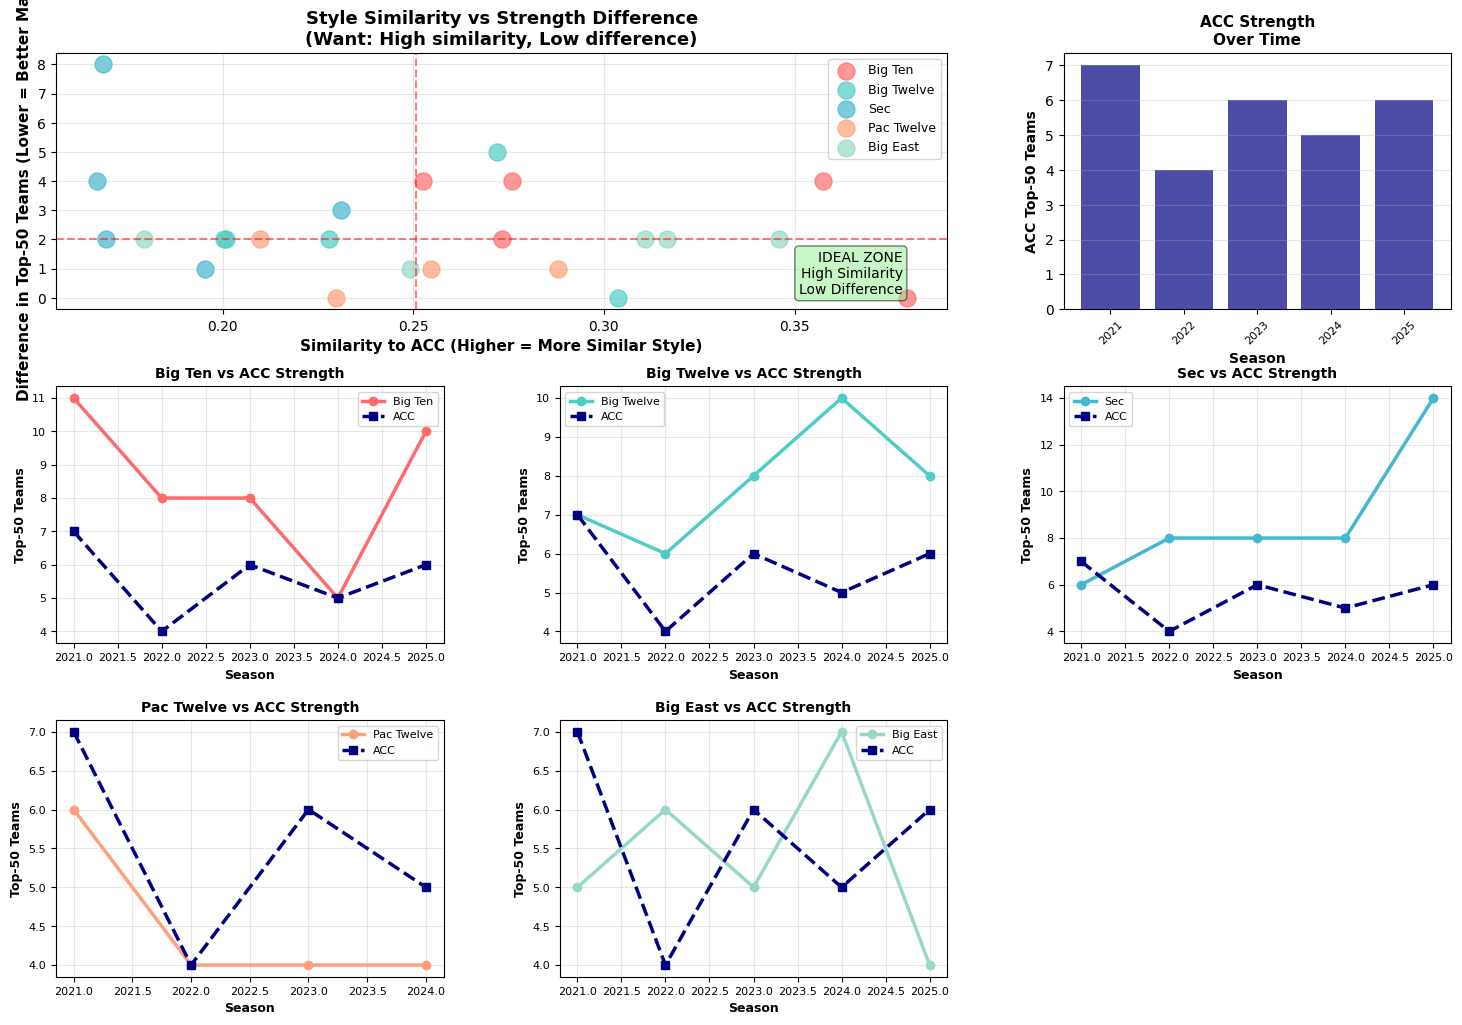


STRENGTH-MATCHED RECOMMENDATIONS FOR TRAINING DATA
Filters: Max Top-50 difference = 3, Min Similarity = 0.3
Only including years when ACC had 3+ teams in top 50

----------------------------------------------------------------------------------------------------
TOP CONFERENCE-YEAR COMBINATIONS:
----------------------------------------------------------------------------------------------------
 Season Conference  Top_50  ACC_Top_50  Top_50_Diff  Similarity_Score  Training_Value_Score
   2024    big_ten       5           5            0          0.379408              1.000000
   2021 big_twelve       7           7            0          0.303686              0.899375
   2022        wcc       4           4            0          0.302602              0.897936
   2024   big_east       7           5            2          0.345869              0.855432
   2025   big_east       4           6            2          0.316624              0.816568
   2021   big_east       5           7           

In [5]:
def analyze_conference_strength_with_massey(df_massey, df_conference, 
                                            ranking_system='POM', 
                                            max_day_num=103, 
                                            top_n_thresholds=[25, 50, 100]):
    """
    Analyze conference strength including ACC's own strength each year
    """
    
    # Filter to specific ranking system and appropriate time window
    rankings = df_massey[
        (df_massey['SystemName'] == ranking_system) & 
        (df_massey['RankingDayNum'] <= max_day_num)
    ].copy()
    
    # For each season, use the latest available ranking before the cutoff
    latest_rankings = rankings.loc[
        rankings.groupby(['Season', 'TeamID'])['RankingDayNum'].idxmax()
    ]
    
    # Merge with conference info
    rankings_with_conf = latest_rankings.merge(
        df_conference, 
        on=['Season', 'TeamID'], 
        how='left'
    )
    
    # Calculate metrics for each conference-season
    conference_strength = []
    
    for season in rankings_with_conf['Season'].unique():
        season_data = rankings_with_conf[rankings_with_conf['Season'] == season]
        
        for conf in season_data['ConfAbbrev'].dropna().unique():
            conf_data = season_data[season_data['ConfAbbrev'] == conf]
            
            metrics = {
                'Season': season,
                'Conference': conf,
                'Total_Teams': len(conf_data),
                'Avg_Rank': conf_data['OrdinalRank'].mean(),
                'Median_Rank': conf_data['OrdinalRank'].median(),
                'Best_Rank': conf_data['OrdinalRank'].min(),
                'Worst_Rank': conf_data['OrdinalRank'].max(),
            }
            
            # Count teams in each threshold
            for threshold in top_n_thresholds:
                metrics[f'Top_{threshold}'] = (conf_data['OrdinalRank'] <= threshold).sum()
                metrics[f'Top_{threshold}_Pct'] = (metrics[f'Top_{threshold}'] / metrics['Total_Teams'] * 100 
                                                    if metrics['Total_Teams'] > 0 else 0)
            
            conference_strength.append(metrics)
    
    return pd.DataFrame(conference_strength)



conference_strength_df = analyze_conference_strength_with_massey(df_massey, df_conferences)


def create_strength_matched_recommendations(yearly_similarity_df, conference_strength_df, 
                                           target_season=2026, lookback_years=5):
    """
    Recommend training data based on:
    1. Style similarity to ACC
    2. ABSOLUTE strength similarity (similar # of top teams)
    """
    
    # Get ACC strength for each year
    acc_strength = conference_strength_df[
        conference_strength_df['Conference'] == 'acc'
    ][['Season', 'Top_25', 'Top_50', 'Top_100', 'Avg_Rank']].copy()
    acc_strength = acc_strength.rename(columns={
        'Top_25': 'ACC_Top_25',
        'Top_50': 'ACC_Top_50',
        'Top_100': 'ACC_Top_100',
        'Avg_Rank': 'ACC_Avg_Rank'
    })
    
    # Merge everything together
    combined = yearly_similarity_df.merge(
        conference_strength_df[['Season', 'Conference', 'Top_25', 'Top_50', 'Top_100', 'Avg_Rank']],
        on=['Season', 'Conference'],
        how='left'
    )
    
    combined = combined.merge(acc_strength, on='Season', how='left')
    
    # Filter to recent years
    recent_cutoff = target_season - lookback_years
    recent_data = combined[combined['Season'] >= recent_cutoff].copy()
    
    # Calculate ABSOLUTE difference in strength (not ratio)
    recent_data['Top_50_Diff'] = np.abs(recent_data['Top_50'] - recent_data['ACC_Top_50'])
    recent_data['Top_25_Diff'] = np.abs(recent_data['Top_25'] - recent_data['ACC_Top_25'])
    recent_data['Avg_Rank_Diff'] = np.abs(recent_data['Avg_Rank'] - recent_data['ACC_Avg_Rank'])
    
    # Normalize similarity score (higher = more similar style)
    recent_data['Style_Score'] = (
        (recent_data['Similarity_Score'] - recent_data['Similarity_Score'].min()) / 
        (recent_data['Similarity_Score'].max() - recent_data['Similarity_Score'].min())
    )
    
    # Strength matching score (lower difference = better match)
    # Normalize so that 0 difference = 1.0, larger differences = lower scores
    max_diff = recent_data['Top_50_Diff'].max()
    recent_data['Strength_Match_Score'] = 1 - (recent_data['Top_50_Diff'] / max_diff)
    
    # Only include years when ACC was reasonably strong
    recent_data['ACC_Quality_Filter'] = (recent_data['ACC_Top_50'] >= 3).astype(int)
    
    # Final composite score
    # 40% style, 40% strength match, 20% ACC quality
    recent_data['Training_Value_Score'] = (
        0.4 * recent_data['Style_Score'] +
        0.4 * recent_data['Strength_Match_Score'] +
        0.2 * recent_data['ACC_Quality_Filter']
    )
    
    return recent_data


def visualize_strength_matching(recent_data):
    """
    Create visualizations focused on strength matching
    """
    power5 = ['big_ten', 'big_twelve', 'sec', 'pac_twelve', 'big_east']
    power5_data = recent_data[recent_data['Conference'].isin(power5)].copy()
    
    fig = plt.figure(figsize=(18, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # Plot 1: Scatter - Style Similarity vs Strength Difference
    ax1 = fig.add_subplot(gs[0, :2])
    
    colors = {'big_ten': '#FF6B6B', 'big_twelve': '#4ECDC4', 'sec': '#45B7D1', 
              'pac_twelve': '#FFA07A', 'big_east': '#98D8C8'}
    
    for conf in power5:
        conf_data = power5_data[power5_data['Conference'] == conf]
        ax1.scatter(conf_data['Similarity_Score'], conf_data['Top_50_Diff'],
                   s=150, alpha=0.7, label=conf.replace('_', ' ').title(),
                   color=colors.get(conf, 'gray'))
    
    ax1.set_xlabel('Similarity to ACC (Higher = More Similar Style)', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Difference in Top-50 Teams (Lower = Better Match)', fontsize=11, fontweight='bold')
    ax1.set_title('Style Similarity vs Strength Difference\n(Want: High similarity, Low difference)', 
                  fontsize=13, fontweight='bold')
    ax1.legend(loc='best', fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Add quadrant lines
    ax1.axvline(power5_data['Similarity_Score'].median(), color='red', linestyle='--', alpha=0.5)
    ax1.axhline(power5_data['Top_50_Diff'].median(), color='red', linestyle='--', alpha=0.5)
    
    # Annotate ideal quadrant
    ax1.text(0.95, 0.05, 'IDEAL ZONE\nHigh Similarity\nLow Difference', 
            transform=ax1.transAxes, fontsize=10, verticalalignment='bottom',
            horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
    
    # Plot 2: ACC Strength over time
    ax2 = fig.add_subplot(gs[0, 2])
    acc_by_year = power5_data[['Season', 'ACC_Top_50']].drop_duplicates().sort_values('Season')
    ax2.bar(acc_by_year['Season'], acc_by_year['ACC_Top_50'], color='navy', alpha=0.7)
    ax2.set_xlabel('Season', fontsize=10, fontweight='bold')
    ax2.set_ylabel('ACC Top-50 Teams', fontsize=10, fontweight='bold')
    ax2.set_title('ACC Strength\nOver Time', fontsize=11, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.tick_params(axis='x', rotation=45, labelsize=8)
    
    # Plot 3-7: Individual conference comparisons to ACC
    for idx, conf in enumerate(power5):
        row = (idx + 3) // 3
        col = (idx + 3) % 3
        ax = fig.add_subplot(gs[row, col])
        
        conf_data = power5_data[power5_data['Conference'] == conf].sort_values('Season')
        
        # Plot both conference and ACC top-50 teams over time
        ax.plot(conf_data['Season'], conf_data['Top_50'], 
               marker='o', linewidth=2.5, label=conf.replace('_', ' ').title(),
               color=colors.get(conf, 'gray'))
        ax.plot(conf_data['Season'], conf_data['ACC_Top_50'], 
               marker='s', linewidth=2.5, label='ACC', color='navy', linestyle='--')
        
        ax.set_xlabel('Season', fontsize=9, fontweight='bold')
        ax.set_ylabel('Top-50 Teams', fontsize=9, fontweight='bold')
        ax.set_title(f'{conf.replace("_", " ").title()} vs ACC Strength', 
                    fontsize=10, fontweight='bold')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.tick_params(labelsize=8)
    
    plt.show()


def print_strength_based_recommendations(recent_data, max_top50_diff=3, min_similarity=0.3):
    """
    Print recommendations based on absolute strength matching
    
    Parameters:
    - max_top50_diff: Maximum acceptable difference in top-50 teams (e.g., 3 means ±3 teams)
    - min_similarity: Minimum similarity score
    """
    
    # Filter to well-matched conference-years
    well_matched = recent_data[
        (recent_data['Top_50_Diff'] <= max_top50_diff) &
        (recent_data['Similarity_Score'] >= min_similarity) &
        (recent_data['ACC_Quality_Filter'] == 1)
    ].copy()
    
    well_matched = well_matched.sort_values('Training_Value_Score', ascending=False)
    
    print("\n" + "="*100)
    print("STRENGTH-MATCHED RECOMMENDATIONS FOR TRAINING DATA")
    print("="*100)
    print(f"Filters: Max Top-50 difference = {max_top50_diff}, Min Similarity = {min_similarity}")
    print(f"Only including years when ACC had 3+ teams in top 50")
    
    print("\n" + "-"*100)
    print("TOP CONFERENCE-YEAR COMBINATIONS:")
    print("-"*100)
    
    display_cols = ['Season', 'Conference', 'Top_50', 'ACC_Top_50', 'Top_50_Diff', 
                    'Similarity_Score', 'Training_Value_Score']
    
    if len(well_matched) > 0:
        print(well_matched[display_cols].head(20).to_string(index=False))
    else:
        print("No matches found with current criteria. Consider relaxing filters.")
    
    # Summary by conference
    print("\n" + "="*100)
    print("" \
    " SUMMARY: Which conferences match ACC's strength profile?")
    print("="*100)
    
    conf_summary = well_matched.groupby('Conference').agg({
        'Season': ['count', lambda x: list(x)],
        'Top_50_Diff': 'mean',
        'Similarity_Score': 'mean',
        'Top_50': 'mean',
        'Training_Value_Score': 'mean'
    }).round(3)
    
    conf_summary.columns = ['Matching_Years', 'Years_List', 'Avg_Top50_Diff', 
                           'Avg_Similarity', 'Avg_Top50_Teams', 'Avg_Value_Score']
    conf_summary = conf_summary.sort_values('Avg_Value_Score', ascending=False)
    
    if len(conf_summary) > 0:
        for conf, row in conf_summary.iterrows():
            print(f"\n{conf.upper()}:")
            print(f"  Matching years: {row['Matching_Years']} → {sorted(row['Years_List'])}")
            print(f"  Avg top-50 teams: {row['Avg_Top50_Teams']:.1f}")
            print(f"  Avg difference from ACC: {row['Avg_Top50_Diff']:.1f} teams")
            print(f"  Avg style similarity: {row['Avg_Similarity']:.3f}")
            print(f"  Value score: {row['Avg_Value_Score']:.3f}")
    
    # Analysis by year - which years have good matches?
    print("\n" + "="*100)
    print("YEAR-BY-YEAR ANALYSIS: Which years have the best conference matches?")
    print("="*100)
    
    year_summary = well_matched.groupby('Season').agg({
        'Conference': lambda x: list(x),
        'Top_50_Diff': 'mean',
        'Training_Value_Score': 'mean'
    }).sort_values('Season', ascending=False)
    
    for season, row in year_summary.iterrows():
        print(f"\n{season}:")
        print(f"  Matched conferences: {[c for c in row['Conference']]}")
        print(f"  Avg strength difference: {row['Top_50_Diff']:.1f} teams")
        print(f"  Avg value score: {row['Training_Value_Score']:.3f}")
    
    # Final recommendations
    print("\n" + "="*100)
    print("FINAL TRAINING DATA RECOMMENDATIONS:")
    print("="*100)
    
    print("\n1. PRIMARY DATA (100% weight):")
    print("   - All ACC games from strong ACC years (3+ top-50 teams)")
    
    if len(conf_summary) > 0:
        print("\n2. SUPPLEMENTARY DATA (Strength-Matched Conferences):")
        for idx, (conf, row) in enumerate(conf_summary.head(3).iterrows(), 1):
            weight = 100 - (idx * 15)  # 85%, 70%, 55%
            print(f"   {idx}. {conf.upper()} ({int(row['Matching_Years'])} matching years) - {weight}% weight")
            print(f"      Years: {sorted(row['Years_List'])}")
            print(f"      Rationale: {row['Avg_Top50_Teams']:.1f} top-50 teams vs ACC's avg, "
                  f"only {row['Avg_Top50_Diff']:.1f} team difference")
    
    print("\n3. DATA TO EXCLUDE OR DOWNWEIGHT:")
    
    # Years when ACC was weak
    all_seasons = recent_data['Season'].unique()
    weak_acc_years = recent_data[recent_data['ACC_Top_50'] < 3]['Season'].unique()
    if len(weak_acc_years) > 0:
        print(f"   - ACC games from weak years: {sorted(weak_acc_years)}")
        print(f"     (Consider 50% weight or exclude entirely)")
    
    # Conferences with large strength mismatches
    poor_matches = recent_data.groupby('Conference')['Top_50_Diff'].mean()
    poor_matches = poor_matches[poor_matches > max_top50_diff].sort_values(ascending=False)
    if len(poor_matches) > 0:
        print(f"\n   - Conferences with strength mismatch (>{max_top50_diff} team difference):")
        for conf, diff in poor_matches.head(5).items():
            print(f"     • {conf.upper()}: avg {diff:.1f} team difference from ACC")
    
    print("\n4. RATIONALE:")
    print("   This approach ensures you're training on games played at similar competitive levels.")
    print("   A conference with 9 top-50 teams plays similar-quality basketball to one with 10.")
    print("   But a conference with 2 top-50 teams is fundamentally different, even if style matches.")

# Example usage:

# After loading your data and calculating yearly_similarity_df and conference_strength_df:

recent_data = create_strength_matched_recommendations(
    yearly_similarity_df, 
    conference_strength_df,
    target_season=2026,
    lookback_years=5
)

visualize_strength_matching(recent_data)

print_strength_based_recommendations(
    recent_data, 
    max_top50_diff=3,  # ±3 top-50 teams is acceptable
    min_similarity=0.3  # Reasonable style similarity threshold
)


In [6]:
TARGET_CONFERENCES = ['acc', 'big_twelve', 'sec', 'big_ten', 'pac_twelve', 'big_east']
teams_in_target_confs = df_conferences[
    df_conferences['ConfAbbrev'].isin(TARGET_CONFERENCES)
]['TeamID'].unique()

# Filter games to only include games where BOTH teams are from target conferences
# df_teams = df_teams[
#     (df_teams['WTeamID'].isin(teams_in_target_confs)) |
#     (df_teams['LTeamID'].isin(teams_in_target_confs))
# ]

In [7]:
def calculate_point_spread(df_teams):
    """
    Calculate home team point spread correctly
    WLoc refers to the WINNING team's location:
    - 'H': Winner was home team
    - 'A': Winner was away team  
    - 'N': Neutral site
    """
    df = df_teams.copy()
    
    # Determine home and away teams based on WLoc
    # If WLoc == 'H': WTeamID is home, LTeamID is away
    # If WLoc == 'A': LTeamID is home, WTeamID is away
    # If WLoc == 'N': Neutral site (we'll use WTeamID as "team1", LTeamID as "team2")
    
    df['HomeTeamID'] = np.where(df['WLoc'] == 'H', df['WTeamID'],
                        np.where(df['WLoc'] == 'A', df['LTeamID'],
                                df['WTeamID']))  # For neutral, just pick one
    
    df['AwayTeamID'] = np.where(df['WLoc'] == 'H', df['LTeamID'],
                        np.where(df['WLoc'] == 'A', df['WTeamID'],
                                df['LTeamID']))
    
    df['HomeScore'] = np.where(df['WLoc'] == 'H', df['WScore'],
                      np.where(df['WLoc'] == 'A', df['LScore'],
                              df['WScore']))  # For neutral, just pick one
    
    df['AwayScore'] = np.where(df['WLoc'] == 'H', df['LScore'],
                      np.where(df['WLoc'] == 'A', df['WScore'],
                              df['LScore']))
    
    # Point spread from home team perspective
    # Positive = home team won by X points
    # Negative = home team lost by X points
    df['HomeSpread'] = df['HomeScore'] - df['AwayScore']
    
    # Mark neutral site games
    df['IsNeutral'] = (df['WLoc'] == 'N').astype(int)
    
    return df

df_games = calculate_point_spread(df_teams)

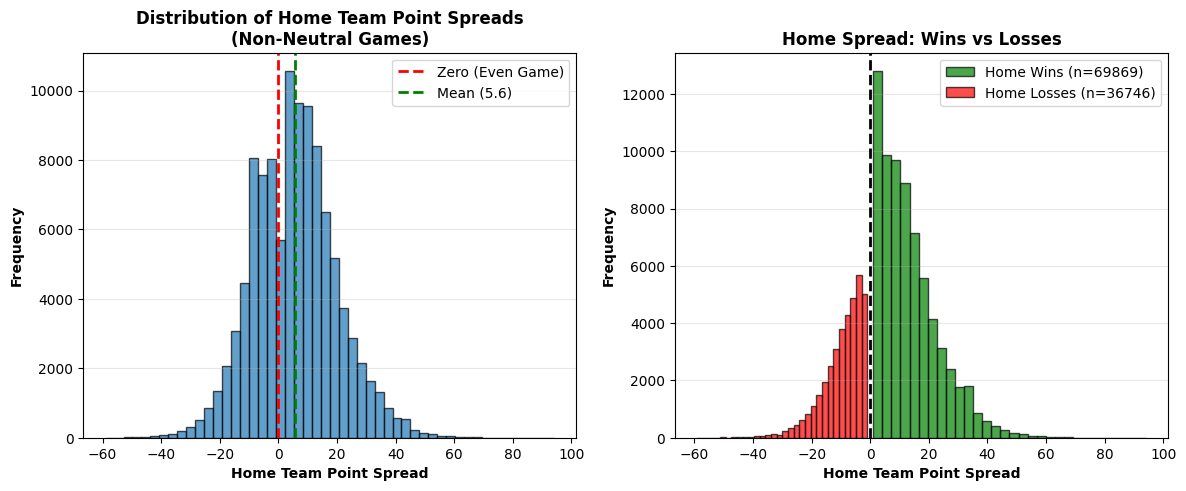

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
home_games = df_games[df_games['IsNeutral'] == 0].copy()
avg_home_spread = home_games['HomeSpread'].mean()
home_team_wins = home_games[home_games['WLoc'] == 'H']
home_team_losses = home_games[home_games['WLoc'] == 'A']
# Overall home spread distribution
ax1 = axes[0]
ax1.hist(home_games['HomeSpread'], bins=50, edgecolor='black', alpha=0.7)
ax1.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero (Even Game)')
ax1.axvline(x=avg_home_spread, color='green', linestyle='--', linewidth=2, 
           label=f'Mean ({avg_home_spread:.1f})')
ax1.set_xlabel('Home Team Point Spread', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')
ax1.set_title('Distribution of Home Team Point Spreads\n(Non-Neutral Games)', 
             fontweight='bold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Win/Loss split
ax2 = axes[1]
ax2.hist(home_team_wins['HomeSpread'], bins=30, alpha=0.7, 
        label=f'Home Wins (n={len(home_team_wins)})', color='green', edgecolor='black')
ax2.hist(home_team_losses['HomeSpread'], bins=30, alpha=0.7, 
        label=f'Home Losses (n={len(home_team_losses)})', color='red', edgecolor='black')
ax2.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax2.set_xlabel('Home Team Point Spread', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')
ax2.set_title('Home Spread: Wins vs Losses', fontweight='bold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

In [10]:
df_games

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LTO,LStl,LBlk,LPF,HomeTeamID,AwayTeamID,HomeScore,AwayScore,HomeSpread,IsNeutral
0,2003,10,1104,68,1328,62,N,0,27,58,...,18,9,2,20,1104,1328,68,62,6,1
1,2003,10,1272,70,1393,63,N,0,26,62,...,12,8,6,16,1272,1393,70,63,7,1
2,2003,11,1266,73,1437,61,N,0,24,58,...,12,2,5,23,1266,1437,73,61,12,1
3,2003,11,1296,56,1457,50,N,0,18,38,...,19,4,3,23,1296,1457,56,50,6,1
4,2003,11,1400,77,1208,71,N,0,30,61,...,10,7,1,14,1400,1208,77,71,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118877,2025,132,1196,86,1397,77,N,0,26,61,...,9,7,5,21,1196,1397,86,77,9,1
118878,2025,132,1272,84,1412,72,N,0,32,68,...,15,5,4,21,1272,1412,84,72,12,1
118879,2025,132,1276,59,1458,53,N,0,19,59,...,6,3,2,14,1276,1458,59,53,6,1
118880,2025,132,1433,68,1206,63,N,0,19,47,...,11,11,3,22,1433,1206,68,63,5,1


In [11]:
import seaborn as sns
# sns.boxplot(data=df_games[(df_games['AConfAbbrev']==df_games['HConfAbbrev'])&(df_games['AConfAbbrev'].isin(TARGET_CONFERENCES))
#                           &(df_games['HConfAbbrev'].isin(TARGET_CONFERENCES))],x='HomeSpread',hue='HConfAbbrev')

In [13]:
# df_games[(df_games['AConfAbbrev']==df_games['HConfAbbrev'])&(df_games['AConfAbbrev'].isin(TARGET_CONFERENCES))
#                           &(df_games['HConfAbbrev'].isin(TARGET_CONFERENCES))].groupby('HConfAbbrev')['HomeSpread'].describe()

In [ ]:
from scipy.stats import linregress

def calculate_elo_ratings(df_games, initial_rating=1500, k=40, alpha=10):
    """
    Calculate Elo ratings with margin of victory adjustment
    """
        
    elo_ratings = {}
    elo_history = []
    
    # Sort by season and day
    df_sorted = df_games.sort_values(['Season', 'DayNum']).copy()
    
    for idx, game in df_sorted.iterrows():
        season = game['Season']
        day = game['DayNum']
        home_id = game['HomeTeamID']
        away_id = game['AwayTeamID']
        home_score = game['HomeScore']
        away_score = game['AwayScore']
        
        # Initialize ratings at start of season
        if season not in elo_ratings:
            elo_ratings[season] = {}
        
        # Get current ratings
        home_elo = elo_ratings[season].get(home_id, initial_rating)
        away_elo = elo_ratings[season].get(away_id, initial_rating)
        
        # Store pre-game Elo
        elo_history.append({
            'Season': season,
            'DayNum': day,
            'TeamID': home_id,
            'Elo_PreGame': home_elo
        })
        elo_history.append({
            'Season': season,
            'DayNum': day,
            'TeamID': away_id,
            'Elo_PreGame': away_elo
        })
        
        # Expected scores
        exp_home = 1 / (1 + 10**((away_elo - home_elo) / 400))
        
        # Actual result
        actual_home = 1 if home_score > away_score else 0
        
        # Margin of victory multiplier
        margin = abs(home_score - away_score)
        mov_multiplier = (margin / alpha) if alpha else 1
        
        # Update ratings
        home_new = home_elo + k * mov_multiplier * (actual_home - exp_home)
        away_new = away_elo + k * mov_multiplier * ((1 - actual_home) - (1 - exp_home))
        
        home_new = max(1, home_new)
        away_new = max(1, away_new)
        
        elo_ratings[season][home_id] = home_new
        elo_ratings[season][away_id] = away_new
    
    elo_df = pd.DataFrame(elo_history)
    
    # Calculate summary statistics per team-season
    elo_summary = elo_df.groupby(['Season', 'TeamID']).agg({
        'Elo_PreGame': ['mean', 'median', 'std', 'min', 'max', 'last']
    }).reset_index()
    
    elo_summary.columns = ['Season', 'TeamID', 'Elo_Mean', 'Elo_Median', 
                           'Elo_Std', 'Elo_Min', 'Elo_Max', 'Elo_Last']
    
    # Calculate trend
    elo_trends = []
    for (season, team_id), group in elo_df.groupby(['Season', 'TeamID']):
        if len(group) > 2:
            trend = linregress(range(len(group)), group['Elo_PreGame']).slope
        else:
            trend = 0
        elo_trends.append({'Season': season, 'TeamID': team_id, 'Elo_Trend': trend})
    
    elo_trends_df = pd.DataFrame(elo_trends)
    elo_summary = elo_summary.merge(elo_trends_df, on=['Season', 'TeamID'])
    
    
    return elo_summary, elo_df

# Calculate Elo
elo_summary, elo_history = calculate_elo_ratings(df_games, initial_rating=1500, k=40, alpha=10)


1. Calculating Elo Ratings...
Calculating Elo trends...
Elo calculated for 7981 team-seasons


In [15]:
def calculate_last_n_games(df_games, n=10):
    """
    Calculate performance metrics from last N games
    """
    
    print(f"\n2. Calculating Last {n} Games Performance...")
    
    # Create team-game records
    home_games = df_games[['Season', 'DayNum', 'HomeTeamID', 'HomeScore', 'AwayScore']].copy()
    home_games.columns = ['Season', 'DayNum', 'TeamID', 'Points', 'OppPoints']
    
    away_games = df_games[['Season', 'DayNum', 'AwayTeamID', 'AwayScore', 'HomeScore']].copy()
    away_games.columns = ['Season', 'DayNum', 'TeamID', 'Points', 'OppPoints']
    
    all_games = pd.concat([home_games, away_games]).sort_values(['Season', 'TeamID', 'DayNum'])
    all_games['Win'] = (all_games['Points'] > all_games['OppPoints']).astype(int)
    
    last_n_stats = []
    
    for (season, team_id), team_data in all_games.groupby(['Season', 'TeamID']):
        team_data = team_data.sort_values('DayNum').reset_index(drop=True)
        
        for idx, row in team_data.iterrows():
            # Get last N games before this day
            prev_games = team_data[team_data['DayNum'] < row['DayNum']].tail(n)
            
            if len(prev_games) == 0:
                continue
            
            stats = {
                'Season': season,
                'TeamID': team_id,
                'DayNum': row['DayNum'],
                f'Last{n}_WinPct': prev_games['Win'].mean(),
                f'Last{n}_PointsMean': prev_games['Points'].mean(),
                f'Last{n}_OppPointsMean': prev_games['OppPoints'].mean(),
                f'Last{n}_PointDiff': prev_games['Points'].mean() - prev_games['OppPoints'].mean(),
                f'Last{n}_NumGames': len(prev_games)
            }
            
            last_n_stats.append(stats)
    
    return pd.DataFrame(last_n_stats)

# Calculate for last 5 and last 10
last_5_stats = calculate_last_n_games(df_games, n=5)
last_10_stats = calculate_last_n_games(df_games, n=10)

# Merge
last_5_stats_home = last_5_stats.rename(columns={'TeamID': 'HomeTeamID'}).add_suffix('_Home')
last_5_stats_away = last_5_stats.rename(columns={'TeamID': 'AwayTeamID'}).add_suffix('_Away')

last_10_stats_home = last_10_stats.rename(columns={'TeamID': 'HomeTeamID'}).add_suffix('_Home')
last_10_stats_away = last_10_stats.rename(columns={'TeamID': 'AwayTeamID'}).add_suffix('_Away')



2. Calculating Last 5 Games Performance...

2. Calculating Last 10 Games Performance...


In [16]:
def calculate_season_aggregates(df_teams, target_conferences):
    """
    Calculate season-level aggregate statistics for each team
    Similar to your season_summary approach
    """
        
    # Filter to target conferences first
    teams_in_target = df_conferences[
        df_conferences['ConfAbbrev'].isin(target_conferences)
    ]['TeamID'].unique()
    
    df_filtered = df_teams[
        (df_teams['WTeamID'].isin(teams_in_target)) &
        (df_teams['LTeamID'].isin(teams_in_target))
    ].copy()
    
    # Create team-game records
    w_games = pd.DataFrame({
        'Season': df_filtered['Season'],
        'DayNum': df_filtered['DayNum'],
        'TeamID': df_filtered['WTeamID'],
        'Points': df_filtered['WScore'],
        'OppPoints': df_filtered['LScore'],
        'FGA': df_filtered['WFGA'],
        'FGA3': df_filtered['WFGA3'],
        'FTA': df_filtered['WFTA'],
        'OR': df_filtered['WOR'],
        'DR': df_filtered['WDR'],
        'Ast': df_filtered['WAst'],
        'TO': df_filtered['WTO'],
        'Stl': df_filtered['WStl'],
        'Blk': df_filtered['WBlk'],
        'OppFGA': df_filtered['LFGA'],
        'OppTO': df_filtered['LTO'],
    })
    
    l_games = pd.DataFrame({
        'Season': df_filtered['Season'],
        'DayNum': df_filtered['DayNum'],
        'TeamID': df_filtered['LTeamID'],
        'Points': df_filtered['LScore'],
        'OppPoints': df_filtered['WScore'],
        'FGA': df_filtered['LFGA'],
        'FGA3': df_filtered['LFGA3'],
        'FTA': df_filtered['LFTA'],
        'OR': df_filtered['LOR'],
        'DR': df_filtered['LDR'],
        'Ast': df_filtered['LAst'],
        'TO': df_filtered['LTO'],
        'Stl': df_filtered['LStl'],
        'Blk': df_filtered['LBlk'],
        'OppFGA': df_filtered['WFGA'],
        'OppTO': df_filtered['WTO'],
    })
    
    all_games = pd.concat([w_games, l_games])
    
    # Calculate season aggregates
    season_summary = (all_games
                     .groupby(['Season', 'TeamID'])
                     .agg(
                         PointsMean=('Points', 'mean'),
                         PointsMedian=('Points', 'median'),
                         OppPointsMean=('OppPoints', 'mean'),
                         FGAMean=('FGA', 'mean'),
                         FGAMedian=('FGA', 'median'),
                         FGA3Mean=('FGA3', 'mean'),
                         FTAMean=('FTA', 'mean'),
                         ORMean=('OR', 'mean'),
                         DRMean=('DR', 'mean'),
                         AstMean=('Ast', 'mean'),
                         TOMean=('TO', 'mean'),
                         StlMean=('Stl', 'mean'),
                         BlkMean=('Blk', 'mean'),
                         OppFGAMean=('OppFGA', 'mean'),
                         OppTOMean=('OppTO', 'mean'),
                     )
                     .assign(PointDiff = lambda x: x['PointsMean'] - x['OppPointsMean'])
                     .reset_index())
        
    return season_summary

season_summary = calculate_season_aggregates(df_teams, TARGET_CONFERENCES)

In [17]:
def get_ranking_for_game(df_games, df_massey, ranking_systems=['POM']):
    """
    For each game on DayNum X, get rankings from the most recent RankingDayNum < X
    
    This ensures we only use information available BEFORE the game
    """
    
    # Filter to desired ranking systems
    rankings = df_massey[df_massey['SystemName'].isin(ranking_systems)].copy()
    
    # Sort by season, team, system, and ranking day
    rankings = rankings.sort_values(['Season', 'TeamID', 'SystemName', 'RankingDayNum'])
    
    # Create a lookup structure for faster access
    rankings_dict = {}
    for system in ranking_systems:
        system_ranks = rankings[rankings['SystemName'] == system]
        for season in system_ranks['Season'].unique():
            season_ranks = system_ranks[system_ranks['Season'] == season]
            if season not in rankings_dict:
                rankings_dict[season] = {}
            rankings_dict[season][system] = season_ranks
    
    game_features = []
    skipped_games = 0

    total_games = len(df_games)
    
    for idx, (game_idx, game) in enumerate(df_games.iterrows()):
        
        season = game['Season']
        game_day = game['DayNum']
        home_team = game['HomeTeamID']
        away_team = game['AwayTeamID']
        
        # Check if we have rankings for this season
        if season not in rankings_dict:
            skipped_games += 1
            continue
        
        # Initialize features
        features = {
            'Season': season,
            'DayNum': game_day,
            'HomeTeamID': home_team,
            'AwayTeamID': away_team,
            'HomeSpread': game['HomeSpread'],
            'IsNeutral': game['IsNeutral']
        }
        
        has_all_rankings = True
        
        for system in ranking_systems:
            # Check if system exists for this season
            if system not in rankings_dict[season]:
                has_all_rankings = False
                break
            
            system_rankings = rankings_dict[season][system]
            
            # Get rankings BEFORE game day
            available_rankings = system_rankings[system_rankings['RankingDayNum'] < game_day]
            
            if len(available_rankings) == 0:
                has_all_rankings = False
                break
            
            # Home team ranking
            home_rankings = available_rankings[available_rankings['TeamID'] == home_team]
            if len(home_rankings) > 0:
                # Get most recent ranking
                latest_home = home_rankings.loc[home_rankings['RankingDayNum'].idxmax()]
                features[f'Home_{system}_Rank'] = latest_home['OrdinalRank']
                features[f'Home_{system}_RankDay'] = latest_home['RankingDayNum']
            else:
                has_all_rankings = False
                break
            
            # Away team ranking
            away_rankings = available_rankings[available_rankings['TeamID'] == away_team]
            if len(away_rankings) > 0:
                latest_away = away_rankings.loc[away_rankings['RankingDayNum'].idxmax()]
                features[f'Away_{system}_Rank'] = latest_away['OrdinalRank']
                features[f'Away_{system}_RankDay'] = latest_away['RankingDayNum']
            else:
                has_all_rankings = False
                break
            
            # Derived feature: ranking difference
            features[f'{system}_RankDiff'] = features[f'Away_{system}_Rank'] - features[f'Home_{system}_Rank']
        
        # Only add if we have all rankings
        if has_all_rankings:
            game_features.append(features)
        else:
            skipped_games += 1
    
    return pd.DataFrame(game_features)


# Use multiple ranking systems
ranking_systems = ['POM']

# Get features for all games
df_model = get_ranking_for_game(df_games, df_massey, ranking_systems)
def create_comprehensive_features(df_model, ranking_systems=['POM', 'MOR', 'DOK', 'MAS', 'SAG']):
    """
    Create multiple representations of rankings with proper handling of edge cases
    """
    df = df_model.copy()
    
    max_rank = 351
    
    for system in ranking_systems:
        # 1. Keep original ranks (for tree models)
        # Already have: Home_{system}_Rank, Away_{system}_Rank, {system}_RankDiff
        
        # 2. Inverse strength (linear relationship)
        # Clip ranks to reasonable range to avoid negatives
        home_rank_clipped = np.clip(df[f'Home_{system}_Rank'], 1, max_rank)
        away_rank_clipped = np.clip(df[f'Away_{system}_Rank'], 1, max_rank)
        
        df[f'Home_{system}_Strength'] = max_rank - home_rank_clipped + 1
        df[f'Away_{system}_Strength'] = max_rank - away_rank_clipped + 1
        df[f'{system}_StrengthDiff'] = df[f'Home_{system}_Strength'] - df[f'Away_{system}_Strength']
        
        # 3. Log strength (diminishing returns at top)
        # Add small epsilon to avoid log(0), use clipped strengths
        df[f'Home_{system}_LogStrength'] = np.log(df[f'Home_{system}_Strength'] + 1)
        df[f'Away_{system}_LogStrength'] = np.log(df[f'Away_{system}_Strength'] + 1)
        
        # 4. Squared inverse (emphasize top teams)
        df[f'Home_{system}_Strength2'] = df[f'Home_{system}_Strength'] ** 2
        df[f'Away_{system}_Strength2'] = df[f'Away_{system}_Strength'] ** 2
        
        # 5. Boolean indicators for elite teams
        df[f'Home_{system}_IsTop25'] = (df[f'Home_{system}_Rank'] <= 25).astype(int)
        df[f'Away_{system}_IsTop25'] = (df[f'Away_{system}_Rank'] <= 25).astype(int)
        df[f'Home_{system}_IsTop50'] = (df[f'Home_{system}_Rank'] <= 50).astype(int)
        df[f'Away_{system}_IsTop50'] = (df[f'Away_{system}_Rank'] <= 50).astype(int)
        
        # 6. Matchup indicators
        df[f'{system}_BothTop25'] = (df[f'Home_{system}_IsTop25'] & df[f'Away_{system}_IsTop25']).astype(int)
        df[f'{system}_BothTop50'] = (df[f'Home_{system}_IsTop50'] & df[f'Away_{system}_IsTop50']).astype(int)
    
    # 7. Consensus features across ranking systems
    rank_cols = [f'Home_{s}_Rank' for s in ranking_systems]
    df['Home_AvgRank'] = df[rank_cols].mean(axis=1)
    df['Home_StdRank'] = df[rank_cols].std(axis=1)  # Disagreement among rankers
    
    rank_cols = [f'Away_{s}_Rank' for s in ranking_systems]
    df['Away_AvgRank'] = df[rank_cols].mean(axis=1)
    df['Away_StdRank'] = df[rank_cols].std(axis=1)
    
    df['AvgRankDiff'] = df['Away_AvgRank'] - df['Home_AvgRank']
    
    # 8. Strength ratio features
    df['Home_BestRank'] = df[[f'Home_{s}_Rank' for s in ranking_systems]].min(axis=1)
    df['Away_BestRank'] = df[[f'Away_{s}_Rank' for s in ranking_systems]].min(axis=1)
    df['Home_WorstRank'] = df[[f'Home_{s}_Rank' for s in ranking_systems]].max(axis=1)
    df['Away_WorstRank'] = df[[f'Away_{s}_Rank' for s in ranking_systems]].max(axis=1)
    
    return df

ranking_systems = ['POM']
df_model_full = create_comprehensive_features(df_model, ranking_systems)

In [18]:
glm_quality = pd.read_csv('glm_quality.csv')

# ============================================================================
# 5. MERGE ALL FEATURES WITH GAMES
# ============================================================================

def merge_all_features(df_model, elo_summary, last_5_stats, last_10_stats, 
                       season_summary, glm_quality):
    """
    Merge all new features with the existing model data
    """
    
    print("\n5. Merging All Features...")
    
    df = df_model.copy()
    
    # Merge Elo - Home team
    df = df.merge(
        elo_summary.rename(columns={'TeamID': 'HomeTeamID'}).add_suffix('_Home'),
        left_on=['Season', 'HomeTeamID'],
        right_on=['Season_Home', 'HomeTeamID_Home'],
        how='left'
    ).drop(columns=['Season_Home', 'HomeTeamID_Home'], errors='ignore')
    
    # Merge Elo - Away team
    df = df.merge(
        elo_summary.rename(columns={'TeamID': 'AwayTeamID'}).add_suffix('_Away'),
        left_on=['Season', 'AwayTeamID'],
        right_on=['Season_Away', 'AwayTeamID_Away'],
        how='left'
    ).drop(columns=['Season_Away', 'AwayTeamID_Away'], errors='ignore')
    
    # Merge Last 5 - need to match on DayNum too
    df = df.merge(
        last_5_stats.rename(columns={'TeamID': 'HomeTeamID'}),
        on=['Season', 'HomeTeamID', 'DayNum'],
        how='left',
        suffixes=('', '_L5_Home')
    )
    
    df = df.merge(
        last_5_stats.rename(columns={'TeamID': 'AwayTeamID'}),
        on=['Season', 'AwayTeamID', 'DayNum'],
        how='left',
        suffixes=('', '_L5_Away')
    )
    
    # Merge Last 10
    df = df.merge(
        last_10_stats.rename(columns={'TeamID': 'HomeTeamID'}),
        on=['Season', 'HomeTeamID', 'DayNum'],
        how='left',
        suffixes=('', '_L10_Home')
    )
    
    df = df.merge(
        last_10_stats.rename(columns={'TeamID': 'AwayTeamID'}),
        on=['Season', 'AwayTeamID', 'DayNum'],
        how='left',
        suffixes=('', '_L10_Away')
    )
    
    # Merge Season Summary - Home
    df = df.merge(
        season_summary.rename(columns={'TeamID': 'HomeTeamID'}).add_suffix('_Home'),
        left_on=['Season', 'HomeTeamID'],
        right_on=['Season_Home', 'HomeTeamID_Home'],
        how='left'
    ).drop(columns=['Season_Home', 'HomeTeamID_Home'], errors='ignore')
    
    # Merge Season Summary - Away
    df = df.merge(
        season_summary.rename(columns={'TeamID': 'AwayTeamID'}).add_suffix('_Away'),
        left_on=['Season', 'AwayTeamID'],
        right_on=['Season_Away', 'AwayTeamID_Away'],
        how='left'
    ).drop(columns=['Season_Away', 'AwayTeamID_Away'], errors='ignore')
    
    # Merge GLM Quality - Home
    df = df.merge(
        glm_quality.rename(columns={'TeamID': 'HomeTeamID', 'quality': 'GLM_Quality_Home'}),
        on=['Season', 'HomeTeamID'],
        how='left'
    )
    
    # Merge GLM Quality - Away
    df = df.merge(
        glm_quality.rename(columns={'TeamID': 'AwayTeamID', 'quality': 'GLM_Quality_Away'}),
        on=['Season', 'AwayTeamID'],
        how='left'
    )
        
    return df

df_model_enhanced = merge_all_features(
    df_model_full, 
    elo_summary, 
    last_5_stats, 
    last_10_stats,
    season_summary,
    glm_quality
)


# ============================================================================
# 6. CREATE DIFFERENTIAL FEATURES
# ============================================================================

def create_differential_features(df):
    """
    Create Home - Away differential features
    """
    
    print("\n6. Creating Differential Features...")
    
    # Elo differentials
    if 'Elo_Last_Home' in df.columns and 'Elo_Last_Away' in df.columns:
        df['Elo_Last_Diff'] = df['Elo_Last_Home'] - df['Elo_Last_Away']
        df['Elo_Mean_Diff'] = df['Elo_Mean_Home'] - df['Elo_Mean_Away']
        df['Elo_Trend_Diff'] = df['Elo_Trend_Home'] - df['Elo_Trend_Away']
    
    # Last N games differentials
    for n in [5, 10]:
        if f'Last{n}_WinPct' in df.columns:
            df[f'Last{n}_WinPct_Diff'] = df[f'Last{n}_WinPct'] - df[f'Last{n}_WinPct_L{n}_Away']
            df[f'Last{n}_PointDiff_Diff'] = df[f'Last{n}_PointDiff'] - df[f'Last{n}_PointDiff_L{n}_Away']
    
    # Season aggregate differentials
    stat_cols = ['PointsMean', 'FGAMean', 'FGA3Mean', 'FTAMean', 
                 'ORMean', 'DRMean', 'AstMean', 'TOMean', 
                 'StlMean', 'BlkMean', 'PointDiff']
    
    for stat in stat_cols:
        home_col = f'{stat}_Home'
        away_col = f'{stat}_Away'
        if home_col in df.columns and away_col in df.columns:
            df[f'{stat}_Diff'] = df[home_col] - df[away_col]
    
    # GLM Quality differential
    if 'GLM_Quality_Home' in df.columns and 'GLM_Quality_Away' in df.columns:
        df['GLM_Quality_Diff'] = df['GLM_Quality_Home'] - df['GLM_Quality_Away']
    
    print(f"Created differentials. New shape: {df.shape}")
    
    return df

df_model_enhanced = create_differential_features(df_model_enhanced)


# ============================================================================
# 7. CLEAN AND PREPARE FINAL DATASET
# ============================================================================


# Replace inf/-inf with NaN
df_model_enhanced = df_model_enhanced.replace([np.inf, -np.inf], np.nan)

# Check missing values
missing_summary = df_model_enhanced.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)



# Drop rows with NaN in key features
id_cols = ['Season', 'DayNum', 'HomeTeamID', 'AwayTeamID', 'HomeSpread', 'IsNeutral']
feature_cols = [col for col in df_model_enhanced.columns if col not in id_cols]

df_model_clean = df_model_enhanced.dropna(subset=['HomeSpread'])  # Keep target variable


enhanced_features = ['IsNeutral']

# 1. POM Ranking features (already have these)
pom_features = [
    'Home_POM_Rank', 'Away_POM_Rank', 'POM_RankDiff',
    'Home_POM_Strength', 'Away_POM_Strength', 'POM_StrengthDiff',
    'Home_POM_LogStrength', 'Away_POM_LogStrength',
    'Home_POM_IsTop25', 'Away_POM_IsTop25',
    'Home_POM_IsTop50', 'Away_POM_IsTop50',
]
enhanced_features.extend(pom_features)

# 2. Elo features
elo_features = [
    'Elo_Last_Home', 'Elo_Last_Away', 'Elo_Last_Diff',
    'Elo_Mean_Home', 'Elo_Mean_Away', 'Elo_Mean_Diff',
    'Elo_Trend_Home', 'Elo_Trend_Away', 'Elo_Trend_Diff',
]
enhanced_features.extend([f for f in elo_features if f in df_model_clean.columns])

# 3. Last 5 and Last 10 games
last_n_features = [
    'Last5_WinPct', 'Last5_WinPct_L5_Away', 'Last5_WinPct_Diff',
    'Last5_PointDiff', 'Last5_PointDiff_L5_Away', 'Last5_PointDiff_Diff',
    'Last10_WinPct', 'Last10_WinPct_L10_Away', 'Last10_WinPct_Diff',
    'Last10_PointDiff', 'Last10_PointDiff_L10_Away', 'Last10_PointDiff_Diff',
]
enhanced_features.extend([f for f in last_n_features if f in df_model_clean.columns])

# 4. Season aggregates and differentials
season_features = [
    'PointsMean_Home', 'PointsMean_Away', 'PointsMean_Diff',
    'PointDiff_Home', 'PointDiff_Away', 'PointDiff_Diff',
    'FGAMean_Home', 'FGAMean_Away', 'FGAMean_Diff',
    'FGA3Mean_Home', 'FGA3Mean_Away', 'FGA3Mean_Diff',
    'AstMean_Home', 'AstMean_Away', 'AstMean_Diff',
    'TOMean_Home', 'TOMean_Away', 'TOMean_Diff',
    'ORMean_Home', 'ORMean_Away', 'ORMean_Diff',
    'DRMean_Home', 'DRMean_Away', 'DRMean_Diff',
]
enhanced_features.extend([f for f in season_features if f in df_model_clean.columns])

# 5. GLM Quality
glm_features = [
    'GLM_Quality_Home', 'GLM_Quality_Away', 'GLM_Quality_Diff'
]
enhanced_features.extend([f for f in glm_features if f in df_model_clean.columns])

# Remove duplicates and filter to existing columns
enhanced_features = list(set(enhanced_features))
enhanced_features = [f for f in enhanced_features if f in df_model_clean.columns]


5. Merging All Features...

6. Creating Differential Features...
Created differentials. New shape: (108547, 122)


In [19]:
df_model_clean['IsHome'] = 1 - df_model_clean['IsNeutral']

In [ ]:
distances = pd.read_csv('data/distances.csv')
df_model_clean = df_model_clean.merge(distances[['Season','DayNum','HTeamId','ATeamID','HTeamName','ATeamName','distance_miles']], left_on= ['Season','DayNum','HomeTeamID','AwayTeamID'],
               right_on= ['Season','DayNum','HTeamId','ATeamID'])

#df_model_clean = df_model_clean.drop(['HTeamId','ATeamID'],axis=1)


In [48]:
#enhanced_features = ['IsNeutral']
enhanced_features = []
enhanced_features.extend(pom_features)
enhanced_features.extend([f for f in elo_features if f in df_model_clean.columns])
enhanced_features.extend([f for f in last_n_features if f in df_model_clean.columns])
enhanced_features.extend([f for f in season_features if f in df_model_clean.columns])
enhanced_features.extend([f for f in glm_features if f in df_model_clean.columns])
enhanced_features.append('IsHome')
# Remove duplicates and filter to existing columns
enhanced_features = list(set(enhanced_features))
enhanced_features = [f for f in enhanced_features if f in df_model_clean.columns]
enhanced_features.extend(['distance_miles'])


TRAINING XGBOOST MODEL
  objective: reg:squarederror
  eval_metric: mae
  max_depth: 8
  eta: 0.05
  subsample: 0.8
  colsample_bytree: 0.8
  min_child_weight: 3
  gamma: 0.2
  lambda: 1.0
  alpha: 0.3
  seed: 42
[0]	train-mae:10.10031	val-mae:10.49635
[50]	train-mae:7.06749	val-mae:8.48039
[100]	train-mae:5.96007	val-mae:8.41795
[145]	train-mae:5.13053	val-mae:8.41844

Best iteration: 120
Best validation MAE: 8.3932

                 MAE       RMSE        R2       N
Train       5.130532   6.526831  0.747715  5825.0
Validation  8.418435  10.530213  0.408246   633.0
Test        7.985494   9.860313  0.462035   321.0

TEST SET DETAILED ANALYSIS

Error Statistics:
  Mean Error: -0.827
  Median Absolute Error: 7.108
  Std of Errors: 9.841

Error Percentiles:
  10th: 1.083
  25th: 3.087
  50th: 7.108
  75th: 11.947
  90th: 15.870
  95th: 18.239

% of predictions within:
   3 points:  24.9%
   5 points:  38.3%
   7 points:  49.2%
  10 points:  64.5%
  15 points:  86.3%

TOP 25 MOST IMPORTANT

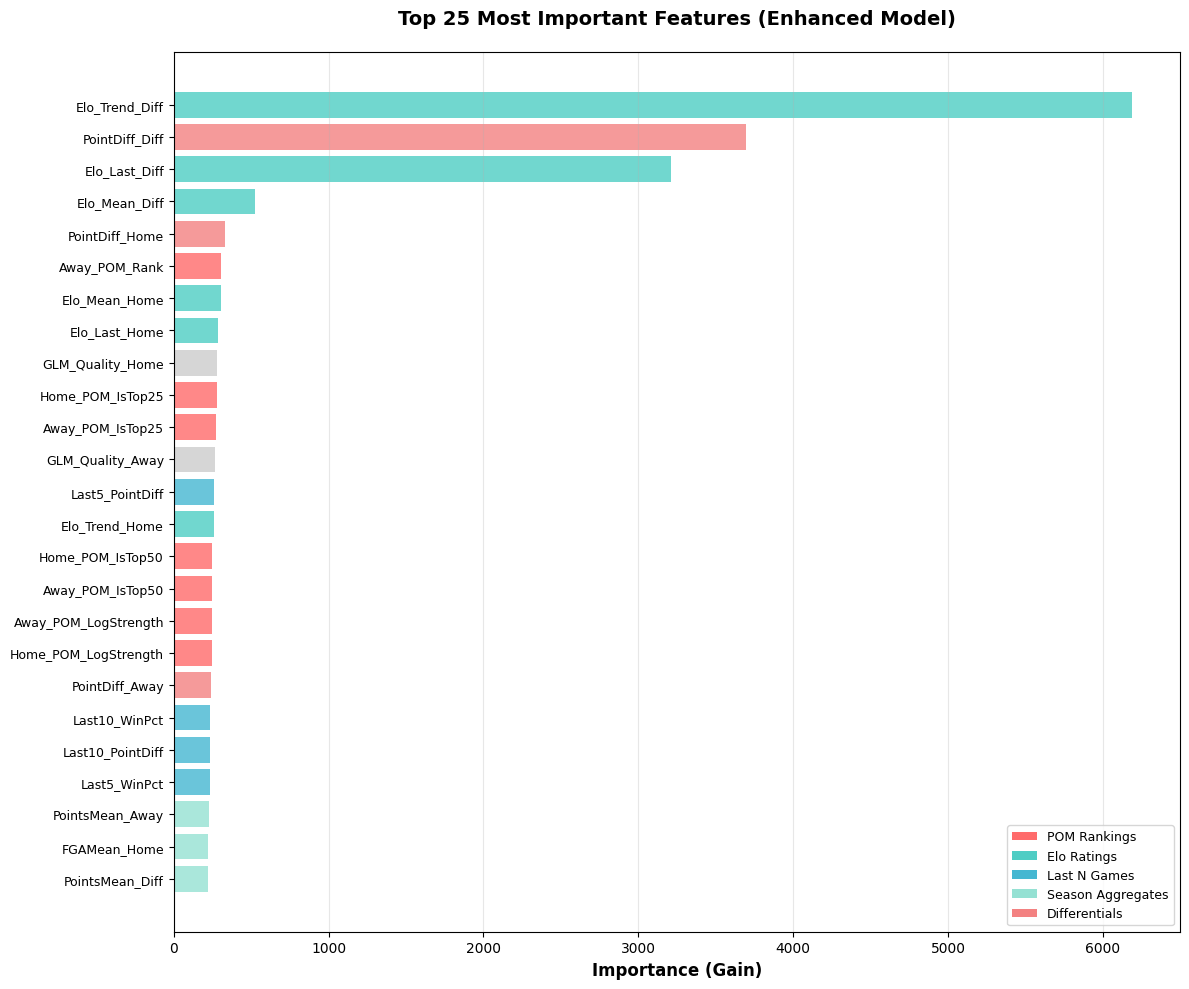

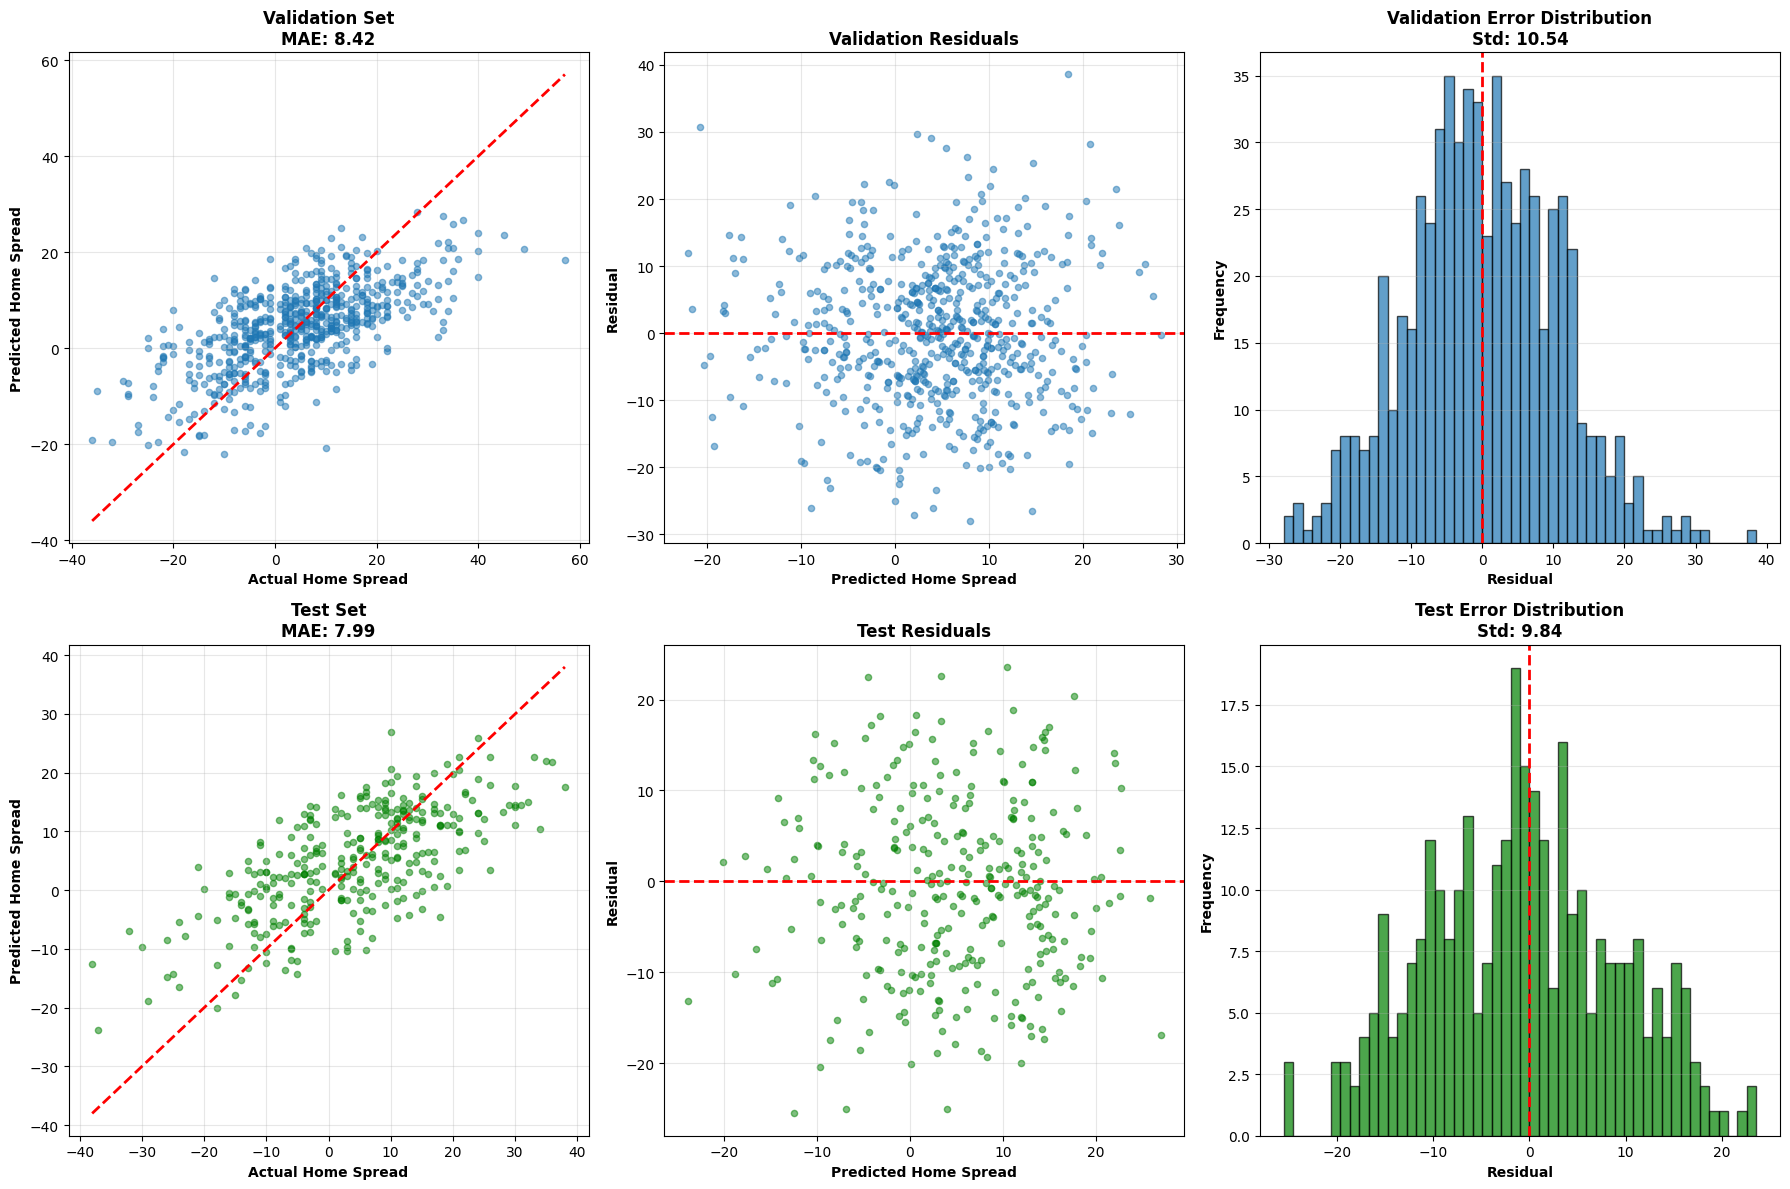


Final Test MAE: 7.985


In [49]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

TARGET_CONFERENCES = ['acc', 'big_twelve', 'sec', 'big_ten', 'pac_twelve', 'big_east']
teams_in_target_confs = df_conferences[
    df_conferences['ConfAbbrev'].isin(TARGET_CONFERENCES)
]['TeamID'].unique()

df_model_clean = df_model_clean[
    (df_model_clean['HomeTeamID'].isin(teams_in_target_confs)) |
    (df_model_clean['AwayTeamID'].isin(teams_in_target_confs))
]

# ============================================================================
# 1. PREPARE DATA SPLITS
# ============================================================================

def prepare_enhanced_data_splits(df_model_clean, enhanced_features, 
                                 train_seasons=range(2015, 2023),
                                 val_seasons=[2023, 2024],
                                 test_season=2025,
                                 target_day_range=(90, 120)):
    """
    Split data with enhanced features
    """
        
    # Check what seasons we actually have
    available_seasons = sorted(df_model_clean['Season'].unique())
    
    train_seasons = [s for s in available_seasons if s not in val_seasons and s != test_season]    
    train_data = df_model_clean[
        (df_model_clean['Season'].isin(train_seasons)) &
        (df_model_clean['DayNum'] <= 120)
    ].copy()
    
    # Validation data: val seasons in target range
    if len(val_seasons) > 0:
        val_data = df_model_clean[
            (df_model_clean['Season'].isin(val_seasons)) &
            (df_model_clean['DayNum'] >= target_day_range[0]) &
            (df_model_clean['DayNum'] <= target_day_range[1])
        ].copy()
    else:
        # If no val seasons, use random split from train
        from sklearn.model_selection import train_test_split
        train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)
    
    # Test data: test season in target range
    test_data = df_model_clean[
        (df_model_clean['Season'] == test_season) &
        (df_model_clean['DayNum'] >= target_day_range[0]) &
        (df_model_clean['DayNum'] <= target_day_range[1])
    ].copy()
    
    # Extract features
    X_train = train_data[enhanced_features].copy()
    y_train = train_data['HomeSpread'].copy()
    
    X_val = val_data[enhanced_features].copy()
    y_val = val_data['HomeSpread'].copy()
    
    X_test = test_data[enhanced_features].copy()
    y_test = test_data['HomeSpread'].copy()
    
    # Drop any remaining NaNs
    train_mask = ~(X_train.isnull().any(axis=1) | y_train.isnull())
    X_train = X_train[train_mask]
    y_train = y_train[train_mask]
    
    val_mask = ~(X_val.isnull().any(axis=1) | y_val.isnull())
    X_val = X_val[val_mask]
    y_val = y_val[val_mask]
    
    test_mask = ~(X_test.isnull().any(axis=1) | y_test.isnull())
    X_test = X_test[test_mask]
    y_test = y_test[test_mask]
    
    
    return X_train, y_train, X_val, y_val, X_test, y_test

#df_model_clean_acc = df_model_clean[(df_model_clean['HomeTeamID'].isin(acc_teams)) | (df_model_clean['AwayTeamID'].isin(acc_teams))&(df_model_clean['IsNeutral']==0)]
df_model_clean_no_neutral = df_model_clean[df_model_clean['IsNeutral']==0]
X_train, y_train, X_val, y_val, X_test, y_test = prepare_enhanced_data_splits(
    df_model_clean,
    enhanced_features,
    train_seasons=range(2015, 2023),
    val_seasons=[2023, 2024],
    test_season=2025
)


# ============================================================================
# 2. DEFINE MONOTONIC CONSTRAINTS
# ============================================================================

def get_enhanced_monotonic_constraints(feature_cols):
    """
    Define monotonic constraints for enhanced features
    """
    
    constraints = []
    
    for col in feature_cols:
        # Neutral site - no constraint
        if col == 'IsNeutral':
            constraints.append(0)
        
        # POM Ranking features (lower rank = better team)
        elif 'Home_POM_Rank' in col and 'Avg' not in col and 'Best' not in col and 'Worst' not in col:
            constraints.append(-1)  # Higher home rank → lower spread
        elif 'Away_POM_Rank' in col and 'Avg' not in col and 'Best' not in col and 'Worst' not in col:
            constraints.append(1)   # Higher away rank → higher spread
        elif 'POM_RankDiff' in col:
            constraints.append(1)   # Positive diff (away worse) → higher spread
        
        # POM Strength features (higher = better)
        elif 'POM_Strength' in col and 'Home' in col and 'Diff' not in col:
            constraints.append(1)   # Higher home strength → higher spread
        elif 'POM_Strength' in col and 'Away' in col and 'Diff' not in col:
            constraints.append(-1)  # Higher away strength → lower spread
        elif 'POM_StrengthDiff' in col:
            constraints.append(1)   # Positive diff (home stronger) → higher spread
        
        # Elo features (higher = better)
        elif 'Elo' in col and 'Home' in col and 'Diff' not in col:
            constraints.append(1)   # Higher home Elo → higher spread
        elif 'Elo' in col and 'Away' in col and 'Diff' not in col:
            constraints.append(-1)  # Higher away Elo → lower spread
        elif 'Elo' in col and 'Diff' in col:
            constraints.append(1)   # Positive diff (home better) → higher spread
        
        # Last N games features
        elif 'Last' in col and 'WinPct' in col and 'Home' in col and 'Diff' not in col:
            constraints.append(1)   # Higher home win % → higher spread
        elif 'Last' in col and 'WinPct' in col and 'Away' in col and 'Diff' not in col:
            constraints.append(-1)  # Higher away win % → lower spread
        elif 'Last' in col and 'PointDiff' in col and 'Home' in col and '_Diff' not in col:
            constraints.append(1)   # Higher home point diff → higher spread
        elif 'Last' in col and 'PointDiff' in col and 'Away' in col and '_Diff' not in col:
            constraints.append(-1)  # Higher away point diff → lower spread
        elif 'Last' in col and '_Diff' in col:
            constraints.append(1)   # Positive diff (home better) → higher spread
        
        # Season aggregate features - Points/PointDiff
        elif 'PointsMean' in col and 'Home' in col and 'Diff' not in col:
            constraints.append(1)   # Higher home scoring → higher spread
        elif 'PointsMean' in col and 'Away' in col and 'Diff' not in col:
            constraints.append(-1)  # Higher away scoring → lower spread
        elif 'PointDiff' in col and 'Home' in col and '_Diff' not in col:
            constraints.append(1)   # Higher home point diff → higher spread
        elif 'PointDiff' in col and 'Away' in col and '_Diff' not in col:
            constraints.append(-1)  # Higher away point diff → lower spread
        
        # All other differential features
        elif '_Diff' in col:
            constraints.append(1)   # Positive diff (home better) → higher spread
        
        # Top team indicators - no constraint (non-linear relationship)
        elif 'IsTop' in col or 'BothTop' in col:
            constraints.append(0)
        
        # Everything else - no constraint
        else:
            constraints.append(0)
    
    return tuple(constraints)

monotonic_constraints = get_enhanced_monotonic_constraints(enhanced_features)


# ============================================================================
# 3. TRAIN XGBOOST MODEL
# ============================================================================

print("\n" + "="*80)
print("TRAINING XGBOOST MODEL")
print("="*80)

# Create DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=enhanced_features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=enhanced_features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=enhanced_features)

# XGBoost parameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'monotone_constraints': monotonic_constraints,
    'max_depth': 8,  
    'eta': 0.05,  
    'subsample': 0.8,  
    'colsample_bytree': 0.8,
    'min_child_weight': 3,  
    'gamma': 0.2,  
    'lambda': 1.0, 
    'alpha': 0.3,  
    'seed': 42
}

for key, value in params.items():
    if key != 'monotone_constraints':
        print(f"  {key}: {value}")

# Train
evals = [(dtrain, 'train'), (dval, 'val')]

enhanced_model = xgb.train(
    params,
    dtrain,
    num_boost_round=2000,
    evals=evals,
    early_stopping_rounds=25,
    verbose_eval=50
)

print(f"\nBest iteration: {enhanced_model.best_iteration}")
print(f"Best validation MAE: {enhanced_model.best_score:.4f}")


# ============================================================================
# 4. EVALUATE MODEL
# ============================================================================

def evaluate_enhanced_model(model, X_train, y_train, X_val, y_val, X_test, y_test, feature_names):
    """
    Comprehensive evaluation of enhanced model
    """
    
    
    # Create DMatrix
    dtrain = xgb.DMatrix(X_train, feature_names=feature_names)
    dval = xgb.DMatrix(X_val, feature_names=feature_names)
    dtest = xgb.DMatrix(X_test, feature_names=feature_names)
    
    # Predictions
    train_pred = model.predict(dtrain)
    val_pred = model.predict(dval)
    test_pred = model.predict(dtest)
    
    # Calculate metrics
    results = {
        'Train': {
            'MAE': mean_absolute_error(y_train, train_pred),
            'RMSE': np.sqrt(mean_squared_error(y_train, train_pred)),
            'R2': r2_score(y_train, train_pred),
            'N': len(y_train)
        },
        'Validation': {
            'MAE': mean_absolute_error(y_val, val_pred),
            'RMSE': np.sqrt(mean_squared_error(y_val, val_pred)),
            'R2': r2_score(y_val, val_pred),
            'N': len(y_val)
        },
        'Test': {
            'MAE': mean_absolute_error(y_test, test_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, test_pred)),
            'R2': r2_score(y_test, test_pred),
            'N': len(y_test)
        }
    }
    
    results_df = pd.DataFrame(results).T
    print("\n" + results_df.to_string())
    
    # Detailed test set analysis
    print("\n" + "="*80)
    print("TEST SET DETAILED ANALYSIS")
    print("="*80)
    
    test_residuals = y_test - test_pred
    
    print(f"\nError Statistics:")
    print(f"  Mean Error: {test_residuals.mean():.3f}")
    print(f"  Median Absolute Error: {np.median(np.abs(test_residuals)):.3f}")
    print(f"  Std of Errors: {test_residuals.std():.3f}")
    
    print(f"\nError Percentiles:")
    for pct in [10, 25, 50, 75, 90, 95]:
        print(f"  {pct}th: {np.percentile(np.abs(test_residuals), pct):.3f}")
    
    print(f"\n% of predictions within:")
    for threshold in [3, 5, 7, 10, 15]:
        within = (np.abs(test_residuals) <= threshold).mean() * 100
        print(f"  {threshold:2d} points: {within:5.1f}%")
    
    return results_df, train_pred, val_pred, test_pred

results_df, train_pred, val_pred, test_pred = evaluate_enhanced_model(
    enhanced_model, X_train, y_train, X_val, y_val, X_test, y_test, enhanced_features
)


# ============================================================================
# 5. FEATURE IMPORTANCE ANALYSIS
# ============================================================================

def plot_enhanced_feature_importance(model, feature_cols, top_n=25):
    """
    Plot feature importance for enhanced model
    """
    
    importance = model.get_score(importance_type='gain')
    
    # Convert to dataframe
    importance_df = pd.DataFrame([
        {'feature': k, 'importance': v} 
        for k, v in importance.items()
    ]).sort_values('importance', ascending=False)
    
    print("\n" + "="*80)
    print(f"TOP {top_n} MOST IMPORTANT FEATURES")
    print("="*80)
    print(importance_df.head(top_n).to_string(index=False))
    
    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    
    top_features = importance_df.head(top_n)
    
    # Color by category
    colors = []
    for feat in top_features['feature']:
        if 'POM' in feat:
            colors.append('#FF6B6B')
        elif 'Elo' in feat:
            colors.append('#4ECDC4')
        elif 'Last' in feat:
            colors.append('#45B7D1')
        elif 'Mean' in feat or 'Median' in feat:
            colors.append('#95E1D3')
        elif 'Diff' in feat:
            colors.append('#F38181')
        else:
            colors.append('#CCCCCC')
    
    ax.barh(range(len(top_features)), top_features['importance'], color=colors, alpha=0.8)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['feature'], fontsize=9)
    ax.set_xlabel('Importance (Gain)', fontweight='bold', fontsize=12)
    ax.set_title(f'Top {top_n} Most Important Features (Enhanced Model)', 
                fontweight='bold', fontsize=14, pad=20)
    ax.grid(axis='x', alpha=0.3)
    ax.invert_yaxis()
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='#FF6B6B', label='POM Rankings'),
        Patch(facecolor='#4ECDC4', label='Elo Ratings'),
        Patch(facecolor='#45B7D1', label='Last N Games'),
        Patch(facecolor='#95E1D3', label='Season Aggregates'),
        Patch(facecolor='#F38181', label='Differentials'),
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    return importance_df

importance_df = plot_enhanced_feature_importance(enhanced_model, enhanced_features, top_n=25)


# ============================================================================
# 6. PREDICTION VISUALIZATIONS
# ============================================================================

def plot_enhanced_predictions(y_val, val_pred, y_test, test_pred):
    """
    Visualize predictions vs actual
    """
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Validation - Scatter
    ax1 = axes[0, 0]
    ax1.scatter(y_val, val_pred, alpha=0.5, s=20)
    min_val = min(y_val.min(), val_pred.min())
    max_val = max(y_val.max(), val_pred.max())
    ax1.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    ax1.set_xlabel('Actual Home Spread', fontweight='bold')
    ax1.set_ylabel('Predicted Home Spread', fontweight='bold')
    ax1.set_title(f'Validation Set\nMAE: {mean_absolute_error(y_val, val_pred):.2f}', 
                 fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Validation - Residuals
    ax2 = axes[0, 1]
    val_residuals = y_val - val_pred
    ax2.scatter(val_pred, val_residuals, alpha=0.5, s=20)
    ax2.axhline(y=0, color='r', linestyle='--', lw=2)
    ax2.set_xlabel('Predicted Home Spread', fontweight='bold')
    ax2.set_ylabel('Residual', fontweight='bold')
    ax2.set_title('Validation Residuals', fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Validation - Histogram
    ax3 = axes[0, 2]
    ax3.hist(val_residuals, bins=50, edgecolor='black', alpha=0.7)
    ax3.axvline(x=0, color='r', linestyle='--', lw=2)
    ax3.set_xlabel('Residual', fontweight='bold')
    ax3.set_ylabel('Frequency', fontweight='bold')
    ax3.set_title(f'Validation Error Distribution\nStd: {val_residuals.std():.2f}', 
                 fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    
    # Test - Scatter
    ax4 = axes[1, 0]
    ax4.scatter(y_test, test_pred, alpha=0.5, s=20, color='green')
    min_val = min(y_test.min(), test_pred.min())
    max_val = max(y_test.max(), test_pred.max())
    ax4.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
    ax4.set_xlabel('Actual Home Spread', fontweight='bold')
    ax4.set_ylabel('Predicted Home Spread', fontweight='bold')
    ax4.set_title(f'Test Set\nMAE: {mean_absolute_error(y_test, test_pred):.2f}', 
                 fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # Test - Residuals
    ax5 = axes[1, 1]
    test_residuals = y_test - test_pred
    ax5.scatter(test_pred, test_residuals, alpha=0.5, s=20, color='green')
    ax5.axhline(y=0, color='r', linestyle='--', lw=2)
    ax5.set_xlabel('Predicted Home Spread', fontweight='bold')
    ax5.set_ylabel('Residual', fontweight='bold')
    ax5.set_title('Test Residuals', fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    # Test - Histogram
    ax6 = axes[1, 2]
    ax6.hist(test_residuals, bins=50, edgecolor='black', alpha=0.7, color='green')
    ax6.axvline(x=0, color='r', linestyle='--', lw=2)
    ax6.set_xlabel('Residual', fontweight='bold')
    ax6.set_ylabel('Frequency', fontweight='bold')
    ax6.set_title(f'Test Error Distribution\nStd: {test_residuals.std():.2f}', 
                 fontweight='bold')
    ax6.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_enhanced_predictions(y_val, val_pred, y_test, test_pred)
print(f"\nFinal Test MAE: {results_df.loc['Test', 'MAE']:.3f}")


In [ ]:
def add_conference_play_features(df, df_conferences):
    """
    Add features indicating conference play and ACC-specific games
    """
    
    # Merge conference info for both teams
    df = df.merge(
        df_conferences[['Season', 'TeamID', 'ConfAbbrev']].rename(
            columns={'TeamID': 'HomeTeamID', 'ConfAbbrev': 'HomeConf'}
        ),
        on=['Season', 'HomeTeamID'],
        how='left'
    )
    
    df = df.merge(
        df_conferences[['Season', 'TeamID', 'ConfAbbrev']].rename(
            columns={'TeamID': 'AwayTeamID', 'ConfAbbrev': 'AwayConf'}
        ),
        on=['Season', 'AwayTeamID'],
        how='left'
    )
    print(df.columns.to_list())
    # Is this a conference game? (both teams in same conference)
    df['IsConferenceGame'] = (df['HomeConf'] == df['AwayConf']).astype(int)
    
    # Is this an ACC game specifically?
    df['IsACCGame'] = (
        (df['HomeConf'] == 'acc') & (df['AwayConf'] == 'acc')
    ).astype(int)
    
    # Is either team from ACC?
    df['HasACCTeam'] = (
        (df['HomeConf'] == 'acc') | (df['AwayConf'] == 'acc')
    ).astype(int)
    
    return df

df_model_clean = add_conference_play_features(df_model_clean, df_conferences)

['Season', 'DayNum', 'HomeTeamID', 'AwayTeamID', 'HomeSpread', 'IsNeutral', 'Home_POM_Rank', 'Home_POM_RankDay', 'Away_POM_Rank', 'Away_POM_RankDay', 'POM_RankDiff', 'Home_POM_Strength', 'Away_POM_Strength', 'POM_StrengthDiff', 'Home_POM_LogStrength', 'Away_POM_LogStrength', 'Home_POM_Strength2', 'Away_POM_Strength2', 'Home_POM_IsTop25', 'Away_POM_IsTop25', 'Home_POM_IsTop50', 'Away_POM_IsTop50', 'POM_BothTop25', 'POM_BothTop50', 'Home_AvgRank', 'Home_StdRank', 'Away_AvgRank', 'Away_StdRank', 'AvgRankDiff', 'Home_BestRank', 'Away_BestRank', 'Home_WorstRank', 'Away_WorstRank', 'Elo_Mean_Home', 'Elo_Median_Home', 'Elo_Std_Home', 'Elo_Min_Home', 'Elo_Max_Home', 'Elo_Last_Home', 'Elo_Trend_Home', 'Elo_Mean_Away', 'Elo_Median_Away', 'Elo_Std_Away', 'Elo_Min_Away', 'Elo_Max_Away', 'Elo_Last_Away', 'Elo_Trend_Away', 'Last5_WinPct', 'Last5_PointsMean', 'Last5_OppPointsMean', 'Last5_PointDiff', 'Last5_NumGames', 'Last5_WinPct_L5_Away', 'Last5_PointsMean_L5_Away', 'Last5_OppPointsMean_L5_Away', 

In [27]:
def add_mismatch_features(df):
    """
    Features that help predict blowouts
    """
    
    # Squared rank difference (emphasizes mismatches)
    if 'POM_RankDiff' in df.columns:
        df['POM_RankDiff_Squared'] = df['POM_RankDiff'] ** 2
    
    # Interaction: Rank diff × Recent form diff
    if 'POM_RankDiff' in df.columns and 'Last5_PointDiff' in df.columns:
        df['Mismatch_x_Form'] = (
            df['POM_RankDiff'] * df['Last5_PointDiff_Diff']
        )
    
    # Elite vs Terrible indicator
    if 'Home_POM_IsTop25' in df.columns and 'Away_POM_Rank' in df.columns:
        df['Elite_vs_Weak'] = (
            df['Home_POM_IsTop25'] * (df['Away_POM_Rank'] > 100).astype(int)
        )
        df['Weak_vs_Elite'] = (
            df['Away_POM_IsTop25'] * (df['Home_POM_Rank'] > 100).astype(int)
        )
    
    # Absolute rank difference bins
    if 'POM_RankDiff' in df.columns:
        df['RankDiff_Magnitude'] = np.abs(df['POM_RankDiff'])
        df['IsHugeMismatch'] = (df['RankDiff_Magnitude'] > 75).astype(int)
        df['IsBigMismatch'] = (df['RankDiff_Magnitude'] > 50).astype(int)
    
    return df

df_model_clean = add_mismatch_features(df_model_clean)

In [62]:
core_features = [
    'Elo_Trend_Diff',
    'PointDiff_Diff', 
    'Elo_Last_Diff',
    'IsHome',
    'distance_miles',
    
    # Secondary Elo features (still useful)
    'Elo_Mean_Diff',
    'Elo_Mean_Home',
    'Elo_Mean_Away',
    'Elo_Trend_Home',
    'Elo_Trend_Away',
    'Elo_Last_Home',
    'Elo_Last_Away',
    
    # Keep GLM quality (shows up in top 25)
    'GLM_Quality_Home',
    'GLM_Quality_Away',
    
    # Keep some POM features (show up in top 25)
    'Home_POM_IsTop25',
    'Away_POM_IsTop25',
    'Home_POM_IsTop50',
    'Away_POM_IsTop50',
    'POM_RankDiff_Squared',
    
    'IsHugeMismatch',
    
    # Recent form
    'Last10_PointDiff',
    'Last10_WinPct',
    'Last5_PointDiff',
    
    # Season aggregates (minimal)
    'PointDiff_Home',
    'PointDiff_Away',
]




In [63]:
core_features.extend(['IsConferenceGame'])

In [200]:
torvik = pd.read_csv('data/barttorvik_15_26.csv')

In [201]:
with zipfile.ZipFile(zip_path) as z:
    with z.open('MTeamSpellings.csv') as f:
        spellings = pd.read_csv(f)

In [202]:
import re

def normalize_name(name):
    name = name.lower()
    name = re.sub(r'[^a-z0-9 ]', ' ', name)   # remove punctuation, replace with space
    name = re.sub(r'\s+', ' ', name).strip()  # collapse whitespace
    return name

In [203]:
spellings = spellings[spellings['TeamID'].isin(teams_in_target_confs)]
spellings['norm'] = spellings['TeamNameSpelling'].apply(normalize_name)

In [204]:
torvik['norm'] = torvik['Team'].apply(normalize_name)

In [205]:
torvik = torvik.drop(['Unnamed: 0.1', 'Unnamed: 0'],axis=1)

In [206]:
# List of columns to clean (as provided in your prompt)
stats_columns = [
    'AdjOE', 'AdjDE', 'Barthag', 'EFG%', 'EFGD%', 'TOR', 'TORD', 
    'ORB', 'DRB', 'FTR', 'FTRD', '2P%', '2P%D', '3P%', '3P%D', 
    '3PR', '3PRD', 'Adj T.', 'WAB'
]

def clean_torvik_stats(df, columns):
    for col in columns:
        if col in df.columns:
            # 1. Ensure the column is string type
            # 2. Split by space and take the first part
            # 3. Convert to numeric, turning errors (like empty strings) into NaN
            df[col] = pd.to_numeric(df[col].astype(str).str.split().str[0], errors='raise')
    return df

# Apply to your dataframe
torvik = clean_torvik_stats(torvik, stats_columns)

In [207]:
with zipfile.ZipFile(zip_path) as z:
    with z.open('MSeasons.csv') as f:
        seasons = pd.read_csv(f)

In [208]:
torvik['Date'] = pd.to_datetime(torvik['Date'])
torvik['Season'] = torvik['Date'].dt.year.astype('int32')
torvik.loc[torvik['Date'].dt.month >= 11, 'Season'] += 1

In [209]:
seasons['DayZero'] = pd.to_datetime(seasons['DayZero'])

torvik = torvik.merge(
    seasons[['Season', 'DayZero']], 
    on='Season', 
    how='left'
)

torvik['DayNum'] = ((torvik['Date'] - torvik['DayZero']).dt.days)+1

torvik = torvik.drop(columns=['DayZero'])

In [210]:
torvik = torvik.merge(spellings,on='norm').drop_duplicates()

In [211]:
df_model_clean['Season'] = df_model_clean['Season'].astype('int32')
df_model_clean['DayNum'] = df_model_clean['DayNum'].astype('float64')

In [213]:
# 2. Sort is MANDATORY for asof
df_model_clean = df_model_clean.sort_values('DayNum')
torvik = torvik.sort_values('DayNum')

# --- HOME TEAM MERGE ---
df_final = pd.merge_asof(
    df_model_clean, 
    torvik[stats_columns + ['TeamID', 'DayNum', 'Season']].rename(columns={'TeamID': 'HomeTeamID'}).dropna(),
    on='DayNum',
    by=['Season', 'HomeTeamID'],
    direction='backward'
).rename(columns={col: f'Home_{col}' for col in stats_columns})

# --- AWAY TEAM MERGE ---
# We do the same, but rename the torvik TeamID to match AwayTeamID
df_final = pd.merge_asof(
    df_final, 
    torvik[stats_columns + ['TeamID', 'DayNum', 'Season']].rename(columns={'TeamID': 'AwayTeamID'}).dropna(),
    on='DayNum',
    by=['Season', 'AwayTeamID'],
    direction='backward'
).rename(columns={col: f'Away_{col}' for col in stats_columns})

In [214]:
df_final = df_final.sort_values(['Season','DayNum'])

In [224]:
for metric in stats_columns:
    home_col = f'Home_{metric}'
    away_col = f'Away_{metric}'
    
    if home_col in df_final.columns and away_col in df_final.columns:
        # Calculate Home - Away
        df_final[f'{metric}_Diff'] = df_final[home_col] - df_final[away_col]

In [215]:
df_model_clean_no_neutral = df_model_clean[df_model_clean['IsNeutral']==0]
def prepare_acc_focused_splits(df_model_clean, feature_cols,
                               train_seasons=range(2015, 2023),
                               val_seasons=[2023, 2024],
                               test_season=2025,
                               target_day_range=(90, 120)):
    """
    Create splits focused on ACC conference games in the last 30 days
    """

    
    # Training: All games from training seasons
    train_data = df_model_clean[
        (df_model_clean['Season'].isin(train_seasons))
    ].copy()
    
    # Validation: ONLY ACC CONFERENCE GAMES in target day range
    val_data = df_model_clean[
        (df_model_clean['Season'].isin(val_seasons)) &
        (df_model_clean['DayNum'] >= target_day_range[0]) &
        (df_model_clean['DayNum'] <= target_day_range[1]) &
        (df_model_clean['IsACCGame'] == 1)  # ACC games only
    ].copy()
    
    test_data = df_model_clean[
        (df_model_clean['Season'] == test_season) &
        (df_model_clean['DayNum'] >= target_day_range[0]) &
        (df_model_clean['DayNum'] <= target_day_range[1]) &
        (df_model_clean['IsACCGame'] == 1)  # ACC games only
    ].copy()
    
    
    # Extract features
    X_train = train_data[feature_cols].copy()
    y_train = train_data['HomeSpread'].copy()
    
    X_val = val_data[feature_cols].copy()
    y_val = val_data['HomeSpread'].copy()
    
    X_test = test_data[feature_cols].copy()
    y_test = test_data['HomeSpread'].copy()
    
    # Drop NaNs
    train_mask = ~(X_train.isnull().any(axis=1) | y_train.isnull())
    X_train = X_train[train_mask]
    y_train = y_train[train_mask]
    
    val_mask = ~(X_val.isnull().any(axis=1) | y_val.isnull())
    X_val = X_val[val_mask]
    y_val = y_val[val_mask]
    
    test_mask = ~(X_test.isnull().any(axis=1) | y_test.isnull())
    X_test = X_test[test_mask]
    y_test = y_test[test_mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Create ACC-focused splits
X_train_acc, y_train_acc, X_val_acc, y_val_acc, X_test_acc, y_test_acc = prepare_acc_focused_splits(
    df_model_clean,
    core_features,
    train_seasons=range(2015, 2023),
    val_seasons=[2023, 2024],
    test_season=2025
)


# Train lean model
X_train_acc = X_train_acc[core_features]
X_val_acc = X_val_acc[core_features]
X_test_acc = X_test_acc[core_features]

# Drop NaNs
train_mask = ~X_train_acc.isnull().any(axis=1)
X_train_acc = X_train_acc[train_mask]
y_train_acc = y_train_acc[train_mask]

val_mask = ~X_val_acc.isnull().any(axis=1)
X_val_acc = X_val_acc[val_mask]
y_val_acc = y_val_acc[val_mask]

test_mask = ~X_test_acc.isnull().any(axis=1)
X_test_acc = X_test_acc[test_mask]
y_test_acc = y_test_acc[test_mask]

# Create DMatrix
dtrain_acc = xgb.DMatrix(X_train_acc, label=y_train_acc, feature_names=core_features)
dval_acc = xgb.DMatrix(X_val_acc, label=y_val_acc, feature_names=core_features)
dtest_acc = xgb.DMatrix(X_test_acc, label=y_test_acc, feature_names=core_features)


# Lean parameters - can be less regularized since fewer features
lean_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'max_depth': 6,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.9,  # Can sample more since fewer features
    'min_child_weight': 3,
    'gamma': 0.1,
    'lambda': 0.8,  # Less regularization needed
    'alpha': 0.2,
    'seed': 42
}

print("\n" + "="*80)
print("TRAINING LEAN MODEL (25 CORE FEATURES)")
print("="*80)

acc_model = xgb.train(
    lean_params,
    dtrain_acc,
    num_boost_round=100,
    evals=[(dtrain_acc, 'train'), (dval_acc, 'val')],
    early_stopping_rounds=50,
    verbose_eval=50
)

# Evaluate
train_pred_acc = acc_model.predict(dtrain_acc)
val_pred_acc = acc_model.predict(dval_acc)
test_pred_acc = acc_model.predict(dtest_acc)

train_mae_acc = mean_absolute_error(y_train_acc, train_pred_acc)
val_mae_acc = mean_absolute_error(y_val_acc, val_pred_acc)
test_mae_acc = mean_absolute_error(y_test_acc, test_pred_acc)

print("\n" + "="*80)
print("LEAN MODEL RESULTS")
print("="*80)
print(f"Train MAE: {train_mae_acc:.3f}")
print(f"Val MAE:   {val_mae_acc:.3f}")
print(f"Test MAE:  {test_mae_acc:.3f}")


TRAINING LEAN MODEL (25 CORE FEATURES)
[0]	train-mae:10.07288	val-mae:10.37440
[50]	train-mae:6.98803	val-mae:9.05902
[99]	train-mae:6.44306	val-mae:9.12998

LEAN MODEL RESULTS
Train MAE: 6.443
Val MAE:   9.130
Test MAE:  8.477


In [233]:
features =  core_features + [f'{i}_Diff' for i in stats_columns]

In [234]:
df_final = df_final[df_final['IsNeutral']==0]

def prepare_acc_focused_splits(df_model_clean, feature_cols,
                               train_seasons=range(2015, 2023),
                               val_seasons=[2023, 2024],
                               test_season=2025,
                               target_day_range=(90, 120)):
    """
    Create splits focused on ACC conference games in the last 30 days
    """

    
    # Training: All games from training seasons
    train_data = df_model_clean[
        (df_model_clean['Season'].isin(train_seasons))
    ].copy()
    
    # Validation: ONLY ACC CONFERENCE GAMES in target day range
    val_data = df_model_clean[
        (df_model_clean['Season'].isin(val_seasons)) &
        (df_model_clean['DayNum'] >= target_day_range[0]) &
        (df_model_clean['DayNum'] <= target_day_range[1]) &
        (df_model_clean['IsACCGame'] == 1)  # ACC games only
    ].copy()
    
    test_data = df_model_clean[
        (df_model_clean['Season'] == test_season) &
        (df_model_clean['DayNum'] >= target_day_range[0]) &
        (df_model_clean['DayNum'] <= target_day_range[1]) &
        (df_model_clean['IsACCGame'] == 1)  # ACC games only
    ].copy()
    
    
    # Extract features
    X_train = train_data[feature_cols].copy()
    y_train = train_data['HomeSpread'].copy()
    
    X_val = val_data[feature_cols].copy()
    y_val = val_data['HomeSpread'].copy()
    
    X_test = test_data[feature_cols].copy()
    y_test = test_data['HomeSpread'].copy()
    
    # Drop NaNs
    train_mask = ~(X_train.isnull().any(axis=1) | y_train.isnull())
    X_train = X_train[train_mask]
    y_train = y_train[train_mask]
    
    val_mask = ~(X_val.isnull().any(axis=1) | y_val.isnull())
    X_val = X_val[val_mask]
    y_val = y_val[val_mask]
    
    test_mask = ~(X_test.isnull().any(axis=1) | y_test.isnull())
    X_test = X_test[test_mask]
    y_test = y_test[test_mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Create ACC-focused splits
X_train_acc, y_train_acc, X_val_acc, y_val_acc, X_test_acc, y_test_acc = prepare_acc_focused_splits(
    df_final,
    features,
    train_seasons=range(2015, 2023),
    val_seasons=[2023, 2024],
    test_season=2025
)


# Train lean model
X_train_acc = X_train_acc[features]
X_val_acc = X_val_acc[features]
X_test_acc = X_test_acc[features]

# Drop NaNs
train_mask = ~X_train_acc.isnull().any(axis=1)
X_train_acc = X_train_acc[train_mask]
y_train_acc = y_train_acc[train_mask]

val_mask = ~X_val_acc.isnull().any(axis=1)
X_val_acc = X_val_acc[val_mask]
y_val_acc = y_val_acc[val_mask]

test_mask = ~X_test_acc.isnull().any(axis=1)
X_test_acc = X_test_acc[test_mask]
y_test_acc = y_test_acc[test_mask]

# Create DMatrix
dtrain_acc = xgb.DMatrix(X_train_acc, label=y_train_acc, feature_names=features)
dval_acc = xgb.DMatrix(X_val_acc, label=y_val_acc, feature_names=features)
dtest_acc = xgb.DMatrix(X_test_acc, label=y_test_acc, feature_names=features)


# Lean parameters - can be less regularized since fewer features
lean_params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'max_depth': 6,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.9,  # Can sample more since fewer features
    'min_child_weight': 3,
    'gamma': 0.1,
    'lambda': 0.8,  # Less regularization needed
    'alpha': 0.2,
    'seed': 42
}

print("\n" + "="*80)
print("TRAINING LEAN MODEL (25 CORE FEATURES)")
print("="*80)

acc_model = xgb.train(
    lean_params,
    dtrain_acc,
    num_boost_round=100,
    evals=[(dtrain_acc, 'train'), (dval_acc, 'val')],
    early_stopping_rounds=50,
    verbose_eval=50
)

# Evaluate
train_pred_acc = acc_model.predict(dtrain_acc)
val_pred_acc = acc_model.predict(dval_acc)
test_pred_acc = acc_model.predict(dtest_acc)

train_mae_acc = mean_absolute_error(y_train_acc, train_pred_acc)
val_mae_acc = mean_absolute_error(y_val_acc, val_pred_acc)
test_mae_acc = mean_absolute_error(y_test_acc, test_pred_acc)

print("\n" + "="*80)
print("LEAN MODEL RESULTS")
print("="*80)
print(f"Train MAE: {train_mae_acc:.3f}")
print(f"Val MAE:   {val_mae_acc:.3f}")
print(f"Test MAE:  {test_mae_acc:.3f}")


TRAINING LEAN MODEL (25 CORE FEATURES)
[0]	train-mae:10.02838	val-mae:10.39528
[50]	train-mae:6.75311	val-mae:9.15738
[99]	train-mae:5.99166	val-mae:9.14004

LEAN MODEL RESULTS
Train MAE: 5.992
Val MAE:   9.140
Test MAE:  8.457


In [237]:
import optuna

def objective(trial):
    # 1. Define the hyperparameter search space
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'mae',
        'verbosity': 0,
        'seed': 42,
        # Tuning range for core complexity
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'eta': trial.suggest_float('eta', 0.01, 0.2, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        
        # Stochastic parameters
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        
        # Regularization
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'lambda': trial.suggest_float('lambda', 0.1, 5.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 1.0, log=True),
    }

    # 2. Train with Early Stopping
    # Note: We use the val set to determine performance
    model = xgb.train(
        params,
        dtrain_acc,
        num_boost_round=500, # Increased rounds because early_stopping handles it
        evals=[(dval_acc, 'val')],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    # 3. Return the metric to minimize (Validation MAE)
    preds = model.predict(dval_acc)
    mae = mean_absolute_error(y_val_acc, preds)
    return mae

# --- Execution ---

# 1. Create a study object
# 'minimize' because we want the lowest Mean Absolute Error
study = optuna.create_study(direction='minimize')

# 2. Run the optimization
print("Starting Hyperparameter Optimization...")
study.optimize(objective, n_trials=500, timeout=600) # Runs for 50 trials or 10 mins

# 3. Results
print("\n" + "="*80)
print("OPTUNA REVEALED BEST PARAMS")
print("="*80)
print(f"Best Val MAE: {study.best_value:.4f}")
print(f"Best Params: {study.best_params}")

# 4. Final Training with Best Params
best_params = {**lean_params, **study.best_params}
final_acc_model = xgb.train(
    best_params,
    dtrain_acc,
    num_boost_round=200,
    evals=[(dtrain_acc, 'train'), (dtest_acc,'test'),(dval_acc, 'val')],
    early_stopping_rounds=50,
    verbose_eval=0
)

# Final Evaluation on Test Set
final_test_pred = final_acc_model.predict(dtest_acc)
final_test_mae = mean_absolute_error(y_test_acc, final_test_pred)
print(f"\nFinal Optimized Test MAE: {final_test_mae:.3f}")

[I 2026-02-05 00:54:28,617] A new study created in memory with name: no-name-2155e67c-c011-4f2d-ba98-49588fac39cc
[I 2026-02-05 00:54:28,798] Trial 0 finished with value: 9.17205810546875 and parameters: {'max_depth': 4, 'eta': 0.0652295414294252, 'min_child_weight': 8, 'subsample': 0.719796080463436, 'colsample_bytree': 0.7800275293934639, 'gamma': 0.3387419986264273, 'lambda': 0.18458774931084188, 'alpha': 0.24128546782425553}. Best is trial 0 with value: 9.17205810546875.


Starting Hyperparameter Optimization...


[I 2026-02-05 00:54:30,158] Trial 1 finished with value: 9.261900901794434 and parameters: {'max_depth': 9, 'eta': 0.013212478876280125, 'min_child_weight': 4, 'subsample': 0.7028718175096197, 'colsample_bytree': 0.959258843380451, 'gamma': 0.2194726156670178, 'lambda': 0.4176015074725292, 'alpha': 0.035341069451666804}. Best is trial 0 with value: 9.17205810546875.
[I 2026-02-05 00:54:30,455] Trial 2 finished with value: 9.271058082580566 and parameters: {'max_depth': 7, 'eta': 0.03119725481921976, 'min_child_weight': 9, 'subsample': 0.9745911960111695, 'colsample_bytree': 0.8476708456824764, 'gamma': 0.4956382005165672, 'lambda': 0.4553235590005268, 'alpha': 0.001133364341566302}. Best is trial 0 with value: 9.17205810546875.
[I 2026-02-05 00:54:30,775] Trial 3 finished with value: 9.157512664794922 and parameters: {'max_depth': 7, 'eta': 0.051205569221429055, 'min_child_weight': 9, 'subsample': 0.6266361350825168, 'colsample_bytree': 0.852041407084105, 'gamma': 0.3015123640805348, '


OPTUNA REVEALED BEST PARAMS
Best Val MAE: 8.7640
Best Params: {'max_depth': 9, 'eta': 0.03775837095737694, 'min_child_weight': 6, 'subsample': 0.6672876094450583, 'colsample_bytree': 0.6949756608779325, 'gamma': 0.27985082997542016, 'lambda': 4.437825556903955, 'alpha': 0.19995718697840587}

Final Optimized Test MAE: 8.912


In [238]:
res = y_test_acc.values - test_pred_acc

low, high = np.percentile(res, [1, 99])
trimmed = res[(res >= low) & (res <= high)]

trimmed_mae = np.mean(np.abs(trimmed))
trimmed_mae

np.float64(8.104195018833066)

In [239]:
low, high = np.percentile(res, [10, 90])
trimmed = res[(res >= low) & (res <= high)]
np.mean(np.abs(trimmed))


np.float64(6.229903594640616)

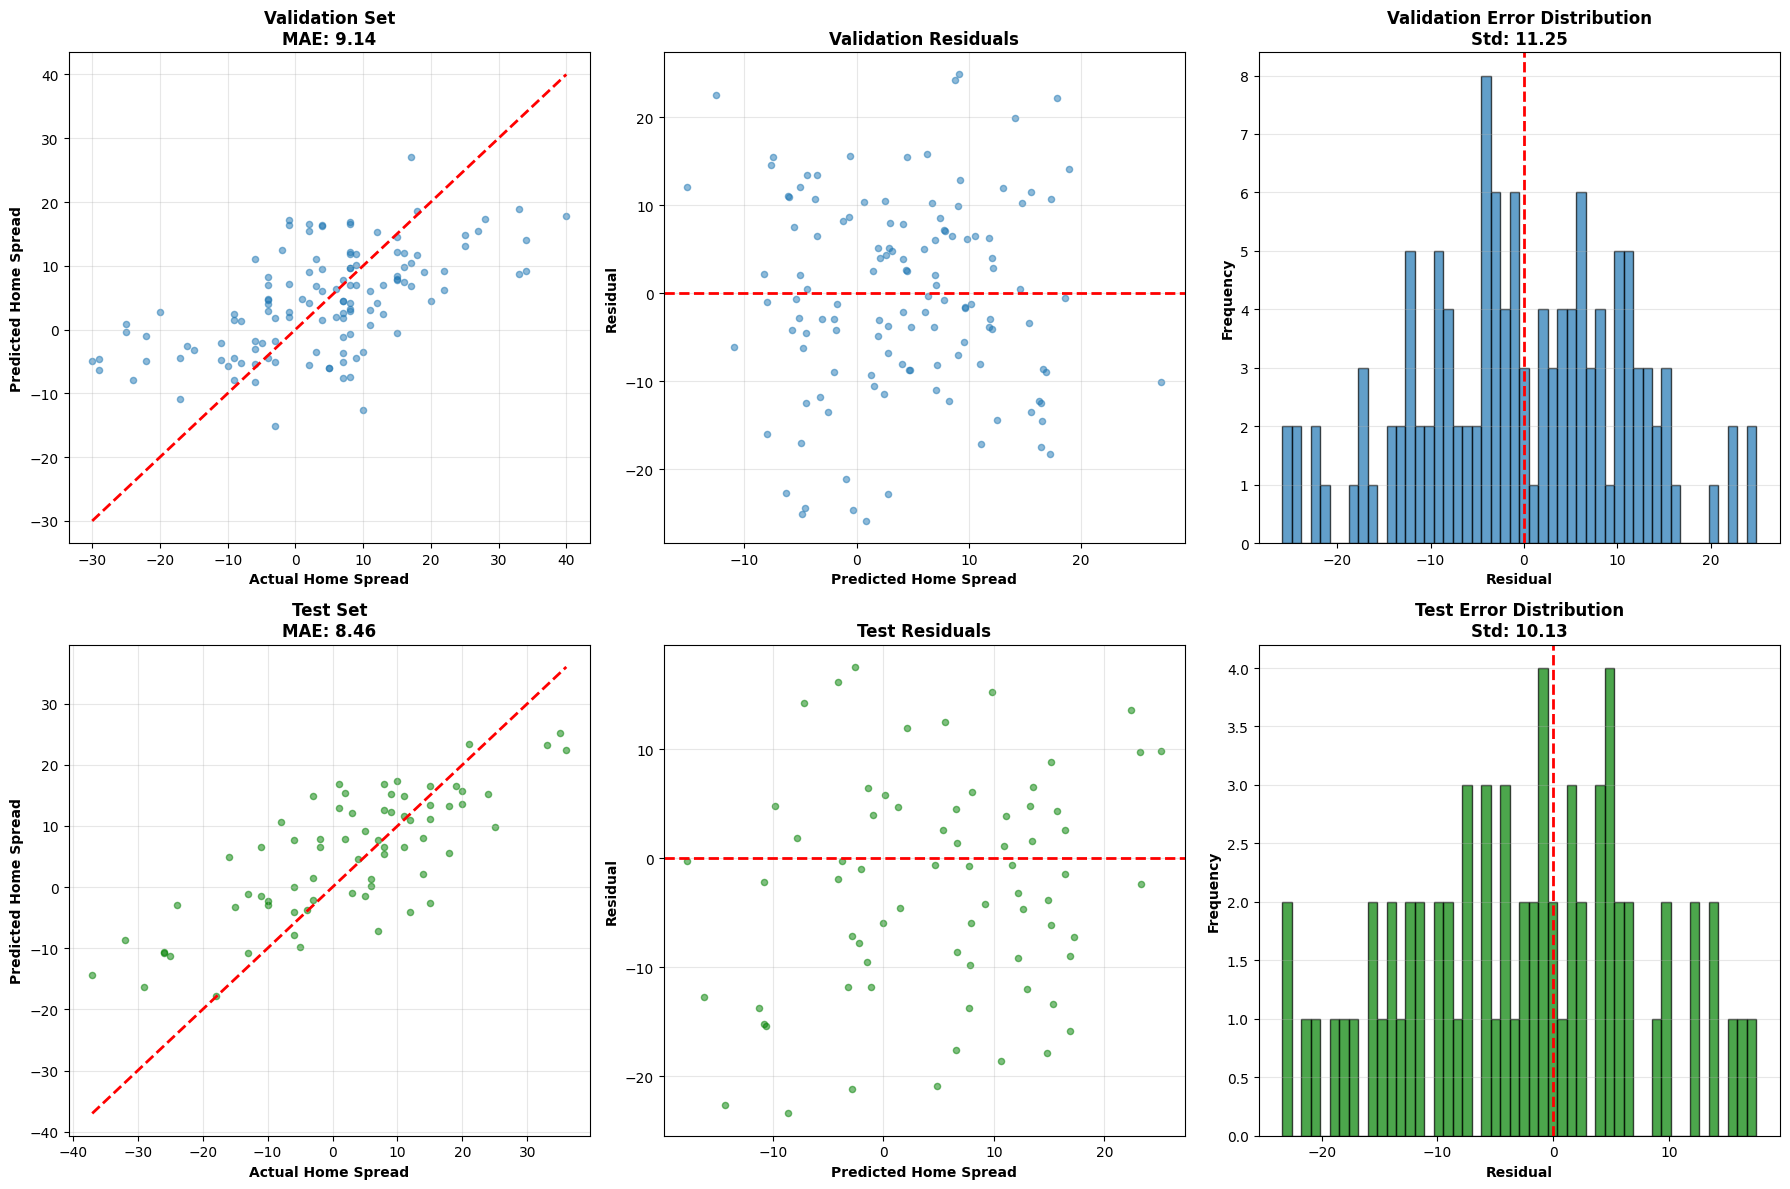

In [240]:
plot_enhanced_predictions(y_val_acc, val_pred_acc, y_test_acc, test_pred_acc)

In [42]:
df_model_clean[core_features].corr()

,Elo_Trend_Diff,PointDiff_Diff,Elo_Last_Diff,IsHome,Elo_Mean_Diff,Elo_Mean_Home,Elo_Mean_Away,Elo_Trend_Home,Elo_Trend_Away,Elo_Last_Home,...,Away_POM_IsTop25,Home_POM_IsTop50,Away_POM_IsTop50,POM_RankDiff_Squared,Last10_PointDiff,Last10_WinPct,Last5_PointDiff,PointDiff_Home,PointDiff_Away,IsConferenceGame
Elo_Trend_Diff,1.000000,0.929622,0.941770,NaN,0.855478,0.561827,-0.642241,0.654215,-0.748877,0.615092,...,-0.404754,0.398850,-0.470195,0.392035,0.467912,0.448456,0.439572,0.586340,-0.647354,-0.252642
PointDiff_Diff,0.929622,1.000000,0.967643,NaN,0.927613,0.642153,-0.639591,0.666628,-0.662991,0.685197,...,-0.446492,0.482676,-0.480976,-0.004439,0.479228,0.465271,0.432872,0.730531,-0.728445,-0.006373
Elo_Last_Diff,0.941770,0.967643,1.000000,NaN,0.946884,0.595949,-0.730035,0.592540,-0.725930,0.631651,...,-0.442961,0.426440,-0.526598,0.478245,0.541497,0.498577,0.495692,0.585260,-0.674800,-0.335034
IsHome,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Elo_Mean_Diff,0.855478,0.927613,0.946884,NaN,1.000000,0.588458,-0.801268,0.500338,-0.692633,0.551498,...,-0.463279,0.414340,-0.559485,0.555970,0.585949,0.526028,0.526299,0.506219,-0.639962,-0.422110
Elo_Mean_Home,0.561827,0.642153,0.595949,NaN,0.588458,1.000000,0.012234,0.857051,0.008177,0.942952,...,0.025008,0.723012,0.025869,0.041670,0.664099,0.611143,0.590947,0.890619,-0.010818,0.017581
Elo_Mean_Away,-0.642241,-0.639591,-0.730035,NaN,-0.801268,0.012234,1.000000,0.015432,0.862647,0.015727,...,0.591454,0.022600,0.711071,-0.656745,-0.232015,-0.197176,-0.212516,0.016715,0.888360,0.535044
Elo_Trend_Home,0.654215,0.666628,0.592540,NaN,0.500338,0.857051,0.015432,1.000000,0.011287,0.940644,...,0.007029,0.625686,0.007335,0.013742,0.547515,0.544615,0.522332,0.907002,-0.025923,0.008697
Elo_Trend_Away,-0.748877,-0.662991,-0.725930,NaN,-0.692633,0.008177,0.862647,0.011287,1.000000,0.011003,...,0.541295,0.020922,0.628085,-0.506278,-0.138977,-0.115754,-0.123554,0.012208,0.903505,0.341646
Elo_Last_Home,0.615092,0.685197,0.631651,NaN,0.551498,0.942952,0.015727,0.940644,0.011003,1.000000,...,0.017079,0.690151,0.016109,0.030548,0.616779,0.584803,0.566878,0.940671,-0.022016,0.014018



TOP 30 MOST IMPORTANT FEATURES
             feature  importance
       Elo_Last_Diff 8493.614258
      PointDiff_Diff 5052.457520
      Elo_Trend_Diff 4992.709473
       Elo_Mean_Diff  845.587097
    Away_POM_IsTop25  684.269409
POM_RankDiff_Squared  668.531799
    GLM_Quality_Away  661.062012
       Last10_WinPct  626.348755
    Last10_PointDiff  624.523743
      PointDiff_Home  623.608826
     Last5_PointDiff  611.635803
           3P%D_Diff  610.391479
    GLM_Quality_Home  608.162109
        Barthag_Diff  590.804504
       Elo_Mean_Home  586.853027
    Away_POM_IsTop50  581.675781
          EFGD%_Diff  577.162659
       Elo_Last_Away  576.811401
            3P%_Diff  568.815308
    IsConferenceGame  565.641235
           3PRD_Diff  563.842651
       Elo_Last_Home  563.231384
            WAB_Diff  558.499634
            ORB_Diff  549.705505
      Elo_Trend_Home  539.815308
            FTR_Diff  539.422913
    Home_POM_IsTop25  534.938965
      PointDiff_Away  534.650330
      Elo_T

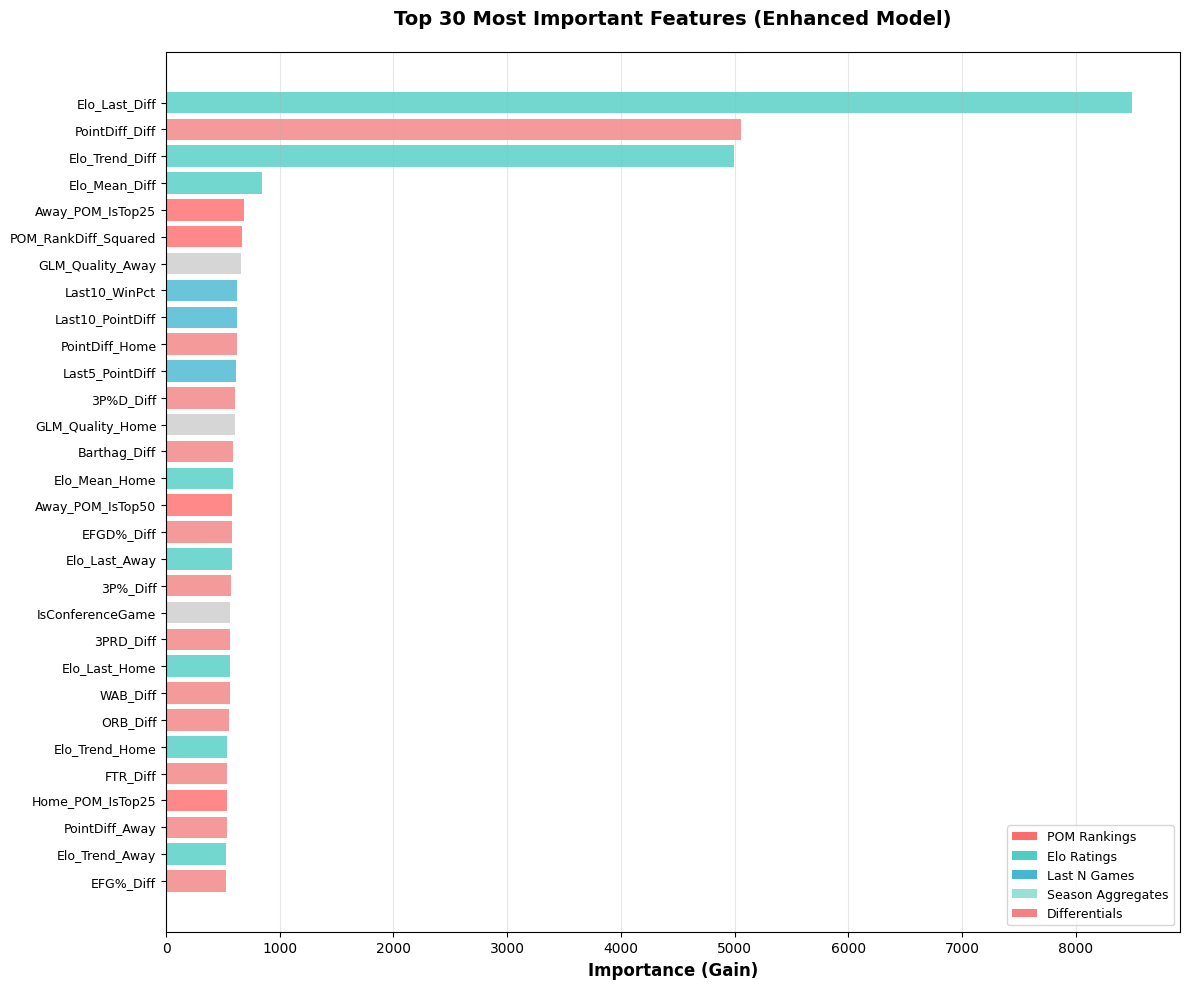

In [241]:
importance_df = plot_enhanced_feature_importance(acc_model, features, top_n=30)

In [192]:
season_2026 = pd.read_csv('data/team_box_26.csv')

In [197]:
season_2026['norm'] = season_2026['team_location'].apply(normalize_name)

In [198]:
season_2026 = season_2026.merge( spellings[['norm', 'TeamID']], on='norm', how='left' )

In [200]:
teams_in_acc = df_conferences[
    df_conferences['ConfAbbrev'].isin(['acc'])
]['TeamID'].unique()

In [211]:
mask = season_2026['team_location'].str.contains('Miami') & \
       ~season_2026['team_location'].str.contains(r'\(OH\)')

season_2026.loc[mask, 'TeamID'] = 1274

In [227]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
from tqdm import tqdm

print("="*80)
print("CALCULATING 2026 PREDICTION FEATURES")
print("="*80)

# Features we need to calculate
REQUIRED_FEATURES = [
    'Elo_Trend_Diff', 'PointDiff_Diff', 'Elo_Last_Diff', 'IsHome',
    'Elo_Mean_Diff', 'Elo_Mean_Home', 'Elo_Mean_Away',
    'Elo_Trend_Home', 'Elo_Trend_Away', 'Elo_Last_Home', 'Elo_Last_Away',
    'GLM_Quality_Home', 'GLM_Quality_Away',
    'Home_POM_IsTop25', 'Away_POM_IsTop25', 'Home_POM_IsTop50', 'Away_POM_IsTop50',
    'POM_RankDiff_Squared', 'Last10_PointDiff', 'Last10_WinPct', 'Last5_PointDiff',
    'PointDiff_Home', 'PointDiff_Away', 'IsConferenceGame'
]

# ============================================================================
# 1. LOAD 2026 DATA
# ============================================================================


season_2026['game_date'] = pd.to_datetime(season_2026['game_date'])
season_2026 = season_2026.sort_values('game_date')

# Create game-level dataset
home_games = season_2026[season_2026['team_home_away'] == 'home'].copy()
away_games = season_2026[season_2026['team_home_away'] == 'away'].copy()

# Merge to get both teams' info
games_2026 = home_games.merge(
    away_games[['game_id', 'TeamID', 'team_score']],
    on='game_id',
    suffixes=('_home', '_away')
)

games_2026 = games_2026.rename(columns={
    'TeamID_home': 'HomeTeamID',
    'TeamID_away': 'AwayTeamID', 
    'team_score_home': 'HomeScore',
    'team_score_away': 'AwayScore'
})

# Filter to games with both TeamIDs
games_2026 = games_2026[games_2026['HomeTeamID'].notna() & games_2026['AwayTeamID'].notna()].copy()

# Basic calculations
games_2026['Season'] = 2026
games_2026['DayNum'] = (games_2026['game_date'] - games_2026['game_date'].min()).dt.days
games_2026['HomeSpread'] = games_2026['HomeScore'] - games_2026['AwayScore']

print(f"Loaded {len(games_2026)} 2026 games with valid TeamIDs")


# ============================================================================
# 2. CALCULATE ELO RATINGS (NEED HISTORICAL + 2026)
# ============================================================================

print("\nCalculating Elo ratings...")

# Combine historical + 2026 for Elo continuity
historical = df_games[df_games['Season'] < 2026][
    ['Season', 'DayNum', 'HomeTeamID', 'AwayTeamID', 'HomeScore', 'AwayScore']
].copy()

games_for_elo = games_2026[
    ['Season', 'DayNum', 'HomeTeamID', 'AwayTeamID', 'HomeScore', 'AwayScore']
].copy()

all_games = pd.concat([historical, games_for_elo]).sort_values(['Season', 'DayNum'])

# Calculate Elo
def calc_elo(df):
    elo_ratings = {}
    elo_history = []
    
    for _, game in tqdm(df.iterrows(), total=len(df), desc="Elo"):
        season, day = game['Season'], game['DayNum']
        home_id, away_id = game['HomeTeamID'], game['AwayTeamID']
        home_score, away_score = game['HomeScore'], game['AwayScore']
        
        if season not in elo_ratings:
            elo_ratings[season] = {}
        
        home_elo = elo_ratings[season].get(home_id, 1500)
        away_elo = elo_ratings[season].get(away_id, 1500)
        
        elo_history.append({'Season': season, 'DayNum': day, 'TeamID': home_id, 'Elo': home_elo})
        elo_history.append({'Season': season, 'DayNum': day, 'TeamID': away_id, 'Elo': away_elo})
        
        # Update
        exp_home = 1 / (1 + 10**((away_elo - home_elo) / 400))
        actual = 1 if home_score > away_score else 0
        margin = abs(home_score - away_score)
        mov = margin / 10
        
        elo_ratings[season][home_id] = max(1, home_elo + 40 * mov * (actual - exp_home))
        elo_ratings[season][away_id] = max(1, away_elo + 40 * mov * ((1-actual) - (1-exp_home)))
    
    df_elo = pd.DataFrame(elo_history)
    
    # Aggregate by team-season
    elo_agg = df_elo.groupby(['Season', 'TeamID']).agg({
        'Elo': ['mean', 'last']
    }).reset_index()
    elo_agg.columns = ['Season', 'TeamID', 'Elo_Mean', 'Elo_Last']
    
    # Calculate trend
    trends = []
    for (s, t), g in df_elo.groupby(['Season', 'TeamID']):
        trend = linregress(range(len(g)), g['Elo']).slope if len(g) > 2 else 0
        trends.append({'Season': s, 'TeamID': t, 'Elo_Trend': trend})
    
    elo_agg = elo_agg.merge(pd.DataFrame(trends), on=['Season', 'TeamID'])
    return elo_agg

elo_all = calc_elo(all_games)
elo_2026 = elo_all[elo_all['Season'] == 2026]

print(f"Elo for {len(elo_2026)} teams")


# ============================================================================
# 3. CALCULATE POINT DIFFERENTIAL (2026 ONLY)
# ============================================================================

print("\nCalculating PointDiff...")

home = games_2026[['HomeTeamID', 'HomeScore', 'AwayScore']]
home.columns = ['TeamID', 'Points', 'OppPoints']

away = games_2026[['AwayTeamID', 'AwayScore', 'HomeScore']]
away.columns = ['TeamID', 'Points', 'OppPoints']

team_games = pd.concat([home, away])

pointdiff_2026 = team_games.groupby('TeamID').apply(
    lambda x: pd.Series({
        'PointDiff': x['Points'].mean() - x['OppPoints'].mean()
    })
).reset_index()

print(f"PointDiff for {len(pointdiff_2026)} teams")


# ============================================================================
# 4. CALCULATE LAST 5 AND LAST 10 (2026 ONLY)
# ============================================================================

print("\nCalculating Last 5 and Last 10...")

def calc_last_n(df, n):
    home = df[['DayNum', 'HomeTeamID', 'HomeScore', 'AwayScore']].copy()
    home.columns = ['DayNum', 'TeamID', 'Points', 'OppPoints']
    away = df[['DayNum', 'AwayTeamID', 'AwayScore', 'HomeScore']].copy()
    away.columns = ['DayNum', 'TeamID', 'Points', 'OppPoints']
    
    tg = pd.concat([home, away]).sort_values(['TeamID', 'DayNum'])
    tg['Win'] = (tg['Points'] > tg['OppPoints']).astype(int)
    
    results = []
    for tid, group in tg.groupby('TeamID'):
        last_n_games = group.tail(n)
        if len(last_n_games) > 0:
            results.append({
                'TeamID': tid,
                f'Last{n}_WinPct': last_n_games['Win'].mean(),
                f'Last{n}_PointDiff': last_n_games['Points'].mean() - last_n_games['OppPoints'].mean()
            })
    return pd.DataFrame(results)

last5 = calc_last_n(games_2026, 5)
last10 = calc_last_n(games_2026, 10)

print(f"Last5: {len(last5)}, Last10: {len(last10)}")


# ============================================================================
# 5. CALCULATE GLM QUALITY (2026 ONLY)
# ============================================================================

print("\nCalculating GLM Quality...")

home = games_2026[['HomeTeamID', 'HomeSpread']]
home.columns = ['TeamID', 'Spread']
away = games_2026[['AwayTeamID', 'HomeSpread']].copy()
away['Spread'] = -away['HomeSpread']
away.columns = ['TeamID','HomeSpread', 'Spread']

glm = pd.concat([home, away]).groupby('TeamID')['Spread'].mean().reset_index()
glm.columns = ['TeamID', 'quality_raw']

# Normalize
glm['GLM_Quality'] = (glm['quality_raw'] - glm['quality_raw'].mean()) / glm['quality_raw'].std()
glm['GLM_Quality'] = np.exp(glm['GLM_Quality']) / np.exp(glm['GLM_Quality']).mean()

print(f"GLM for {len(glm)} teams")


# ============================================================================
# 6. GET POM RANKINGS (EXTERNAL DATA)
# ============================================================================

print("\nGetting POM rankings...")

# Option 1: Load from Massey data if you have it
# Option 2: Use 2025 end-of-season as proxy
# Option 3: Scrape from KenPom

if 'df_massey' in globals():
    pom = df_massey[(df_massey['Season'] == 2026) & (df_massey['SystemName'] == 'POM')]
    
    if len(pom) == 0:
        print("  No 2026 POM, using 2025 proxy...")
        pom = df_massey[(df_massey['Season'] == 2025) & (df_massey['SystemName'] == 'POM')]
        pom = pom[pom['RankingDayNum'] == pom['RankingDayNum'].max()]
    
    pom = pom[['TeamID', 'OrdinalRank']].drop_duplicates()
    pom['POM_IsTop25'] = (pom['OrdinalRank'] <= 25).astype(int)
    pom['POM_IsTop50'] = (pom['OrdinalRank'] <= 50).astype(int)
    
    print(f"  POM for {len(pom)} teams")
else:
    print("  WARNING: No POM data! Will fill with defaults")
    pom = pd.DataFrame()


# ============================================================================
# 7. GET CONFERENCE INFO (EXTERNAL DATA)
# ============================================================================

print("\nGetting conference info...")


conf = df_conferences[df_conferences['Season'].isin([2025, 2026])]
conf = conf.drop_duplicates('TeamID', keep='last')[['TeamID', 'ConfAbbrev']]


# ============================================================================
# 8. BUILD PREDICTION DATASET
# ============================================================================

print("\n" + "="*80)
print("BUILDING PREDICTION FEATURES")
print("="*80)

pred = games_2026[['game_id', 'game_date', 'HomeTeamID', 'AwayTeamID']].copy()
pred['Season'] = 2026
pred['IsHome'] = 1

# Merge Elo - Home
pred = pred.merge(elo_2026.rename(columns={'TeamID': 'HomeTeamID'}).add_suffix('_Home'),
                  left_on=['Season', 'HomeTeamID'], 
                  right_on=['Season_Home', 'HomeTeamID_Home'],
                  how='left').drop(['Season_Home', 'HomeTeamID_Home'], axis=1, errors='ignore')

# Merge Elo - Away
pred = pred.merge(elo_2026.rename(columns={'TeamID': 'AwayTeamID'}).add_suffix('_Away'),
                  left_on=['Season', 'AwayTeamID'],
                  right_on=['Season_Away', 'AwayTeamID_Away'],
                  how='left').drop(['Season_Away', 'AwayTeamID_Away'], axis=1, errors='ignore')

# Elo diffs
pred['Elo_Last_Diff'] = pred['Elo_Last_Home'] - pred['Elo_Last_Away']
pred['Elo_Mean_Diff'] = pred['Elo_Mean_Home'] - pred['Elo_Mean_Away']
pred['Elo_Trend_Diff'] = pred['Elo_Trend_Home'] - pred['Elo_Trend_Away']

# PointDiff
pred = pred.merge(pointdiff_2026.rename(columns={'TeamID': 'HomeTeamID', 'PointDiff': 'PointDiff_Home'}), on='HomeTeamID', how='left')
pred = pred.merge(pointdiff_2026.rename(columns={'TeamID': 'AwayTeamID', 'PointDiff': 'PointDiff_Away'}), on='AwayTeamID', how='left')
pred['PointDiff_Diff'] = pred['PointDiff_Home'] - pred['PointDiff_Away']

# Last 5
pred = pred.merge(last5.rename(columns={'TeamID': 'HomeTeamID'}).add_suffix('_Home'),
                  left_on='HomeTeamID', right_on='HomeTeamID_Home', how='left').drop('HomeTeamID_Home', axis=1, errors='ignore')

# Last 10
pred = pred.merge(last10.rename(columns={'TeamID': 'HomeTeamID'}), on='HomeTeamID', how='left')

# GLM
pred = pred.merge(glm[['TeamID', 'GLM_Quality']].rename(columns={'TeamID': 'HomeTeamID', 'GLM_Quality': 'GLM_Quality_Home'}), on='HomeTeamID', how='left')
pred = pred.merge(glm[['TeamID', 'GLM_Quality']].rename(columns={'TeamID': 'AwayTeamID', 'GLM_Quality': 'GLM_Quality_Away'}), on='AwayTeamID', how='left')

# POM
if len(pom) > 0:
    pred = pred.merge(pom[['TeamID', 'POM_IsTop25', 'POM_IsTop50', 'OrdinalRank']].rename(
        columns={'TeamID': 'HomeTeamID'}
    ).add_suffix('_Home'), left_on='HomeTeamID', right_on='HomeTeamID_Home', how='left').drop('HomeTeamID_Home', axis=1, errors='ignore')
    
    pred = pred.merge(pom[['TeamID', 'POM_IsTop25', 'POM_IsTop50', 'OrdinalRank']].rename(
        columns={'TeamID': 'AwayTeamID'}
    ).add_suffix('_Away'), left_on='AwayTeamID', right_on='AwayTeamID_Away', how='left').drop('AwayTeamID_Away', axis=1, errors='ignore')
    
    pred['POM_RankDiff'] = pred['OrdinalRank_Away'] - pred['OrdinalRank_Home']
    pred['POM_RankDiff_Squared'] = pred['POM_RankDiff'] ** 2

# Conference
if len(conf) > 0:
    pred = pred.merge(conf.rename(columns={'TeamID': 'HomeTeamID', 'ConfAbbrev': 'HomeConf'}), on='HomeTeamID', how='left')
    pred = pred.merge(conf.rename(columns={'TeamID': 'AwayTeamID', 'ConfAbbrev': 'AwayConf'}), on='AwayTeamID', how='left')
    pred['IsConferenceGame'] = (pred['HomeConf'] == pred['AwayConf']).astype(int)
else:
    pred['IsConferenceGame'] = 0

# Fill missing values
for feat in REQUIRED_FEATURES:
    if feat not in pred.columns:
        pred[feat] = 0  # Add missing features
    
    if pred[feat].isnull().any():
        if 'Elo' in feat:
            pred[feat].fillna(1500, inplace=True)
        elif 'POM' in feat and 'IsTop' in feat:
            pred[feat].fillna(0, inplace=True)
        elif 'POM' in feat:
            pred[feat].fillna(175, inplace=True)
        elif 'GLM' in feat:
            pred[feat].fillna(1.0, inplace=True)
        else:
            pred[feat].fillna(0, inplace=True)

print(f"\nPrediction dataset: {len(pred)} games")
print(f"Features: {len(REQUIRED_FEATURES)}")

# Check completeness
missing = pred[REQUIRED_FEATURES].isnull().sum()
if missing.sum() > 0:
    print(f"\nWARNING: Still have missing values:")
    print(missing[missing > 0])
else:
    print("\n✅ All features complete!")

# Save
pred.to_csv('2026_predictions_ready.csv', index=False)
print("\nSaved to: 2026_predictions_ready.csv")

CALCULATING 2026 PREDICTION FEATURES
Loaded 923 2026 games with valid TeamIDs

Calculating Elo ratings...


Elo: 100%|██████████| 39445/39445 [00:01<00:00, 30582.38it/s]


Elo for 82 teams

Calculating PointDiff...
PointDiff for 82 teams

Calculating Last 5 and Last 10...
Last5: 82, Last10: 82

Calculating GLM Quality...
GLM for 82 teams

Getting POM rankings...
  No 2026 POM, using 2025 proxy...
  POM for 364 teams

Getting conference info...

BUILDING PREDICTION FEATURES

Prediction dataset: 923 games
Features: 24

✅ All features complete!

Saved to: 2026_predictions_ready.csv


In [ ]:
d2026 = xgb.DMatrix(pred[core_features],feature_names=core_features)

array([ 8.37757874e+00,  1.51301289e+01,  1.73629532e+01,  1.59016502e+00,
        1.59016502e+00,  2.78683162e+00,  8.83545780e+00,  8.83545780e+00,
        1.31473989e+01,  1.31473989e+01, -5.17306376e+00,  5.86884499e+00,
        5.86884499e+00, -3.37623000e+00, -1.26402283e+01, -7.26388216e+00,
       -7.26388216e+00,  1.73680916e+01,  1.73680916e+01,  1.73680916e+01,
        1.73680916e+01,  4.27683306e+00,  9.75375175e+00,  9.75375175e+00,
        1.62612019e+01,  1.62612019e+01,  1.94066982e+01,  1.94066982e+01,
        2.46919379e-01,  1.29724956e+00, -5.33520126e+00, -5.33520126e+00,
        1.73272479e+00,  1.73272479e+00,  2.03172445e+00,  1.97588654e+01,
        1.97588654e+01, -2.15323806e+00,  1.56386569e-02, -3.69492960e+00,
       -3.69492960e+00, -5.40912962e+00,  1.21846056e+01,  1.11240168e+01,
        1.37638779e+01,  1.20943308e+01,  8.42981529e+00, -7.40402842e+00,
        4.78526020e+00, -8.48426151e+00,  1.41497517e+01,  8.48727894e+00,
        8.48727894e+00,  

In [235]:
mean_absolute_error(games_2026['HomeSpread'],acc_model.predict(d2026))

8.677681922912598